In [1]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV


In [2]:
pd.set_option('display.max_rows', None)

In [3]:
param_dist_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],        # số láng giềng để xem xét
    'weights': ['uniform', 'distance'],     # cách tính trọng số cho các láng giềng
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # thuật toán tìm láng giềng
    'p': [1, 2]                            # tham số khoảng cách (1 = Manhattan, 2 = Euclidean)
}


In [4]:
from sklearn.neighbors import KNeighborsClassifier
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize

def train_phase(phase_path, n_iter=10, random_state=42, sample=False):
    best_model = None
    best_score = 0
    all_metrics = []
    best_params = None

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train.columns)

        if fold == 1:
            clf = KNeighborsClassifier()
            search = RandomizedSearchCV(
                clf,
                param_distributions=param_dist_knn,
                n_iter=n_iter,
                cv=3,
                n_jobs=-1,
                verbose=1,
                scoring='f1_macro'
            )
            search.fit(X_train_scaled, y_train)
            best_params = search.best_params_
            print(f"[Fold 1] Best Parameters Found: {best_params}")

        model = KNeighborsClassifier(**best_params)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
        
        # KNN supports predict_proba, so keep it
        y_proba = model.predict_proba(X_val_scaled)

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')

        classes = model.classes_
        y_val_bin = label_binarize(y_val, classes=classes)
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val, y_pred))

        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes, yticklabels=classes)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {cls}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    # Không có feature_importances trong KNN nên bỏ phần này

    return best_model, best_scaler, best_fold, all_metrics




============== Training Phase 1 ===============

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'weights': 'distance', 'p': 2, 'n_neighbors': 3, 'algorithm': 'brute'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.82      0.79      1785
           1       0.44      0.37      0.40       604
           2       0.35      0.33      0.34       258
           3       0.33      0.31      0.32        59
           4       0.20      0.11      0.14         9

    accuracy                           0.66      2715
   macro avg       0.42      0.39      0.40      2715
weighted avg       0.64      0.66      0.65      2715



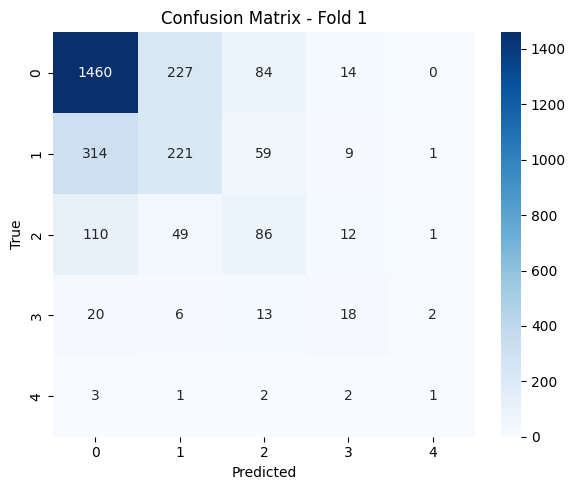

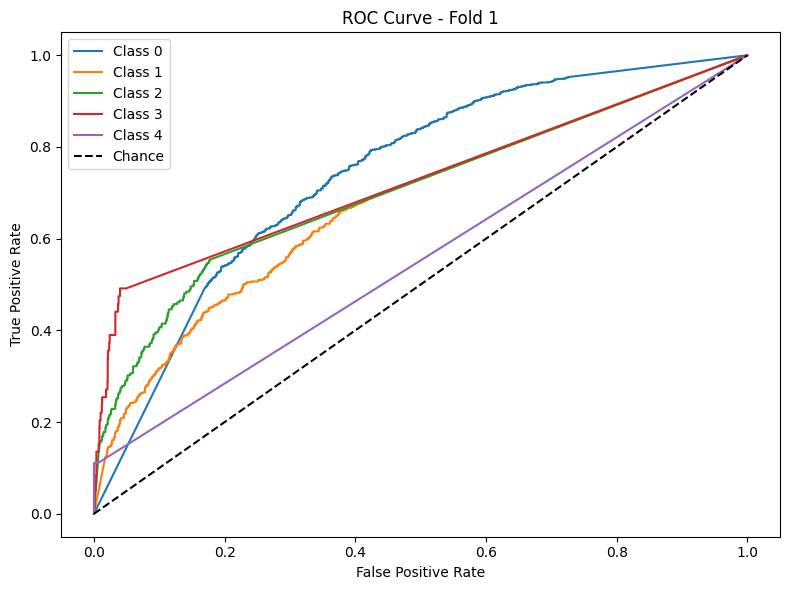


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.81      0.79      1786
           1       0.43      0.39      0.41       603
           2       0.38      0.33      0.35       258
           3       0.30      0.27      0.28        59
           4       0.00      0.00      0.00         8

    accuracy                           0.66      2714
   macro avg       0.38      0.36      0.37      2714
weighted avg       0.65      0.66      0.65      2714



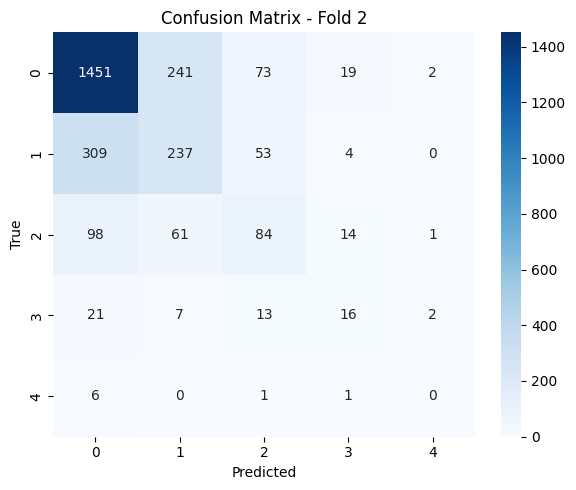

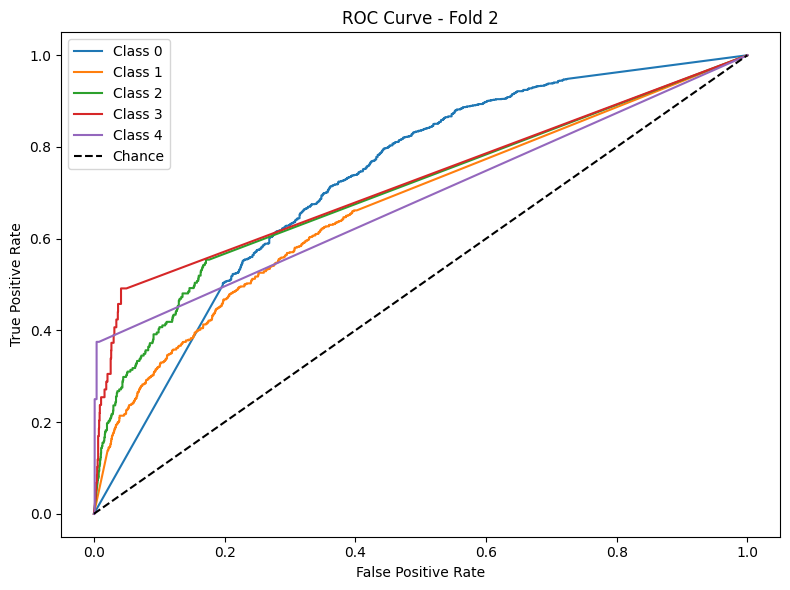


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.81      0.79      1786
           1       0.42      0.36      0.39       603
           2       0.38      0.36      0.37       258
           3       0.25      0.22      0.24        59
           4       0.12      0.12      0.12         8

    accuracy                           0.65      2714
   macro avg       0.39      0.38      0.38      2714
weighted avg       0.64      0.65      0.65      2714



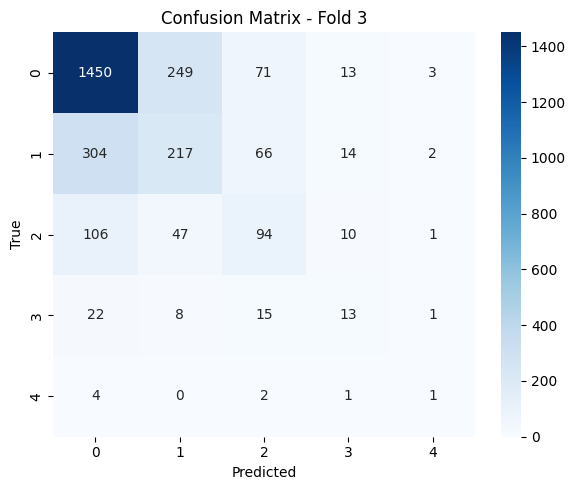

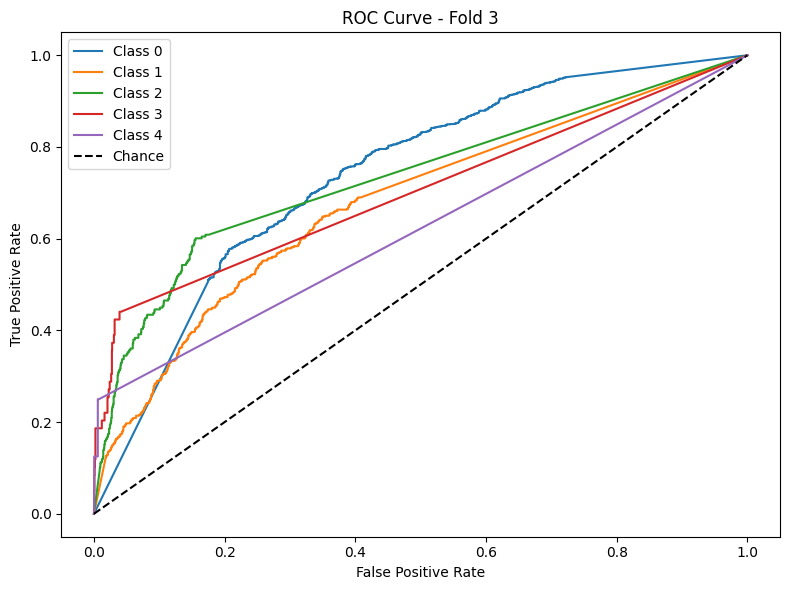


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.83      0.80      1785
           1       0.44      0.37      0.40       603
           2       0.41      0.37      0.39       258
           3       0.34      0.27      0.30        59
           4       0.00      0.00      0.00         9

    accuracy                           0.67      2714
   macro avg       0.39      0.37      0.38      2714
weighted avg       0.65      0.67      0.66      2714



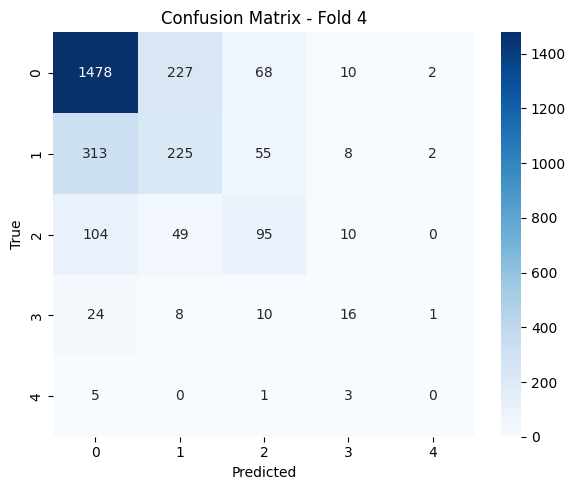

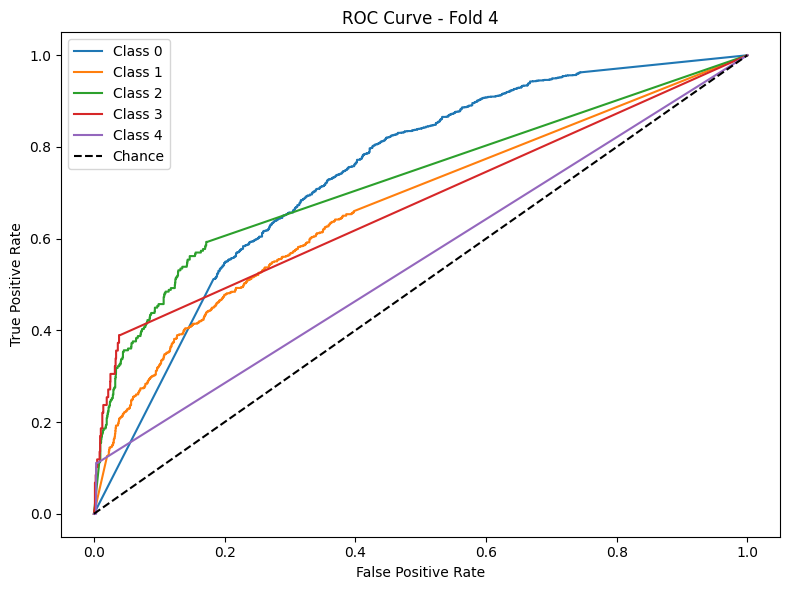


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.81      0.79      1785
           1       0.41      0.37      0.39       603
           2       0.37      0.32      0.34       258
           3       0.18      0.14      0.15        59
           4       0.25      0.11      0.15         9

    accuracy                           0.65      2714
   macro avg       0.39      0.35      0.36      2714
weighted avg       0.63      0.65      0.64      2714



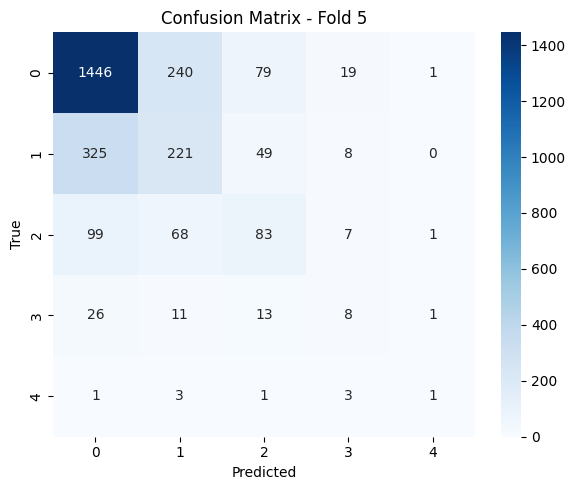

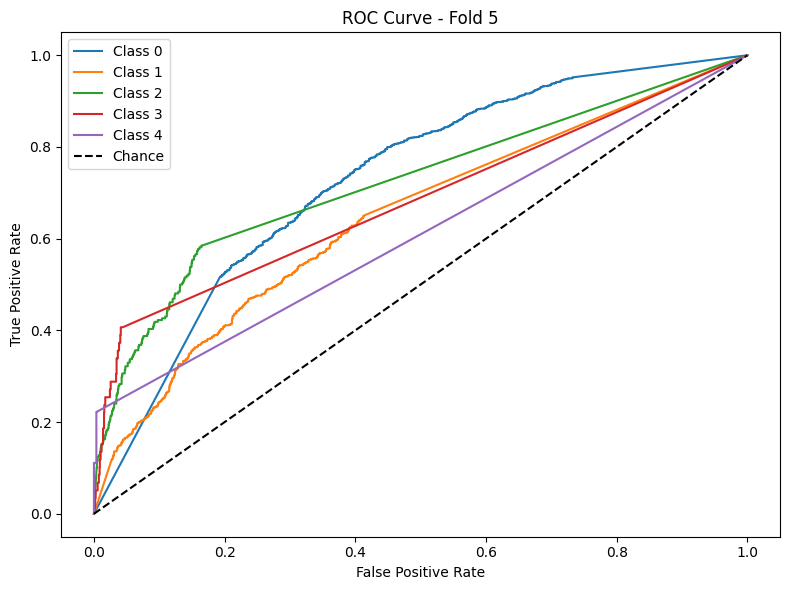


Average Accuracy: 0.6574
Average F1 Macro: 0.3780
Average AUC: 0.6860


============== Training Phase 2 ===============

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'weights': 'distance', 'p': 1, 'n_neighbors': 3, 'algorithm': 'ball_tree'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80      1489
           1       0.41      0.35      0.38       488
           2       0.32      0.31      0.32       220
           3       0.28      0.28      0.28        54
           4       0.25      0.22      0.24         9

    accuracy                           0.65      2260
   macro avg       0.41      0.40      0.40      2260
weighted avg       0.64      0.65      0.65      2260



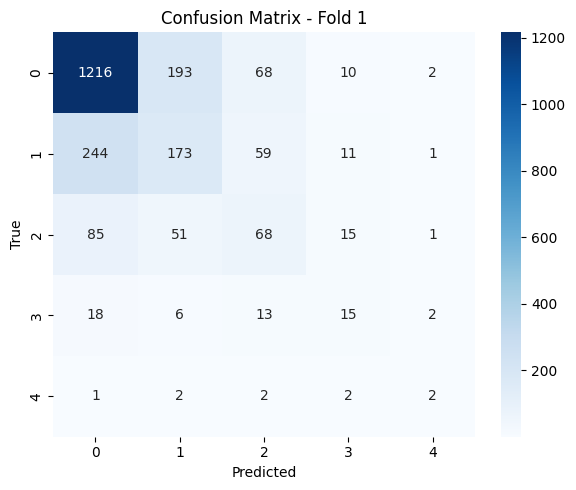

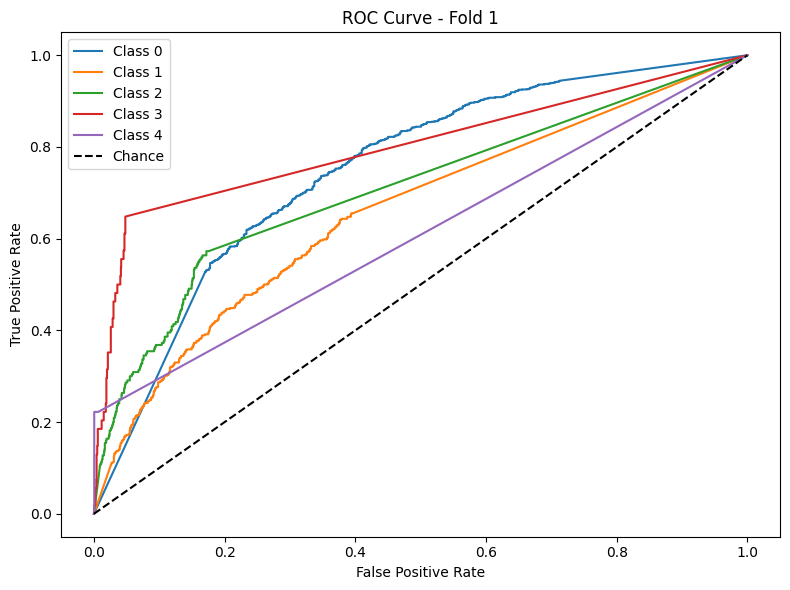


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.82      0.79      1489
           1       0.41      0.36      0.38       489
           2       0.39      0.32      0.35       219
           3       0.24      0.24      0.24        55
           4       0.17      0.12      0.14         8

    accuracy                           0.66      2260
   macro avg       0.39      0.37      0.38      2260
weighted avg       0.64      0.66      0.65      2260



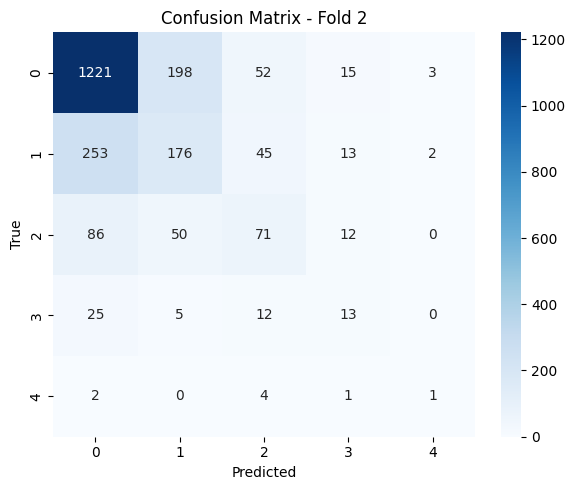

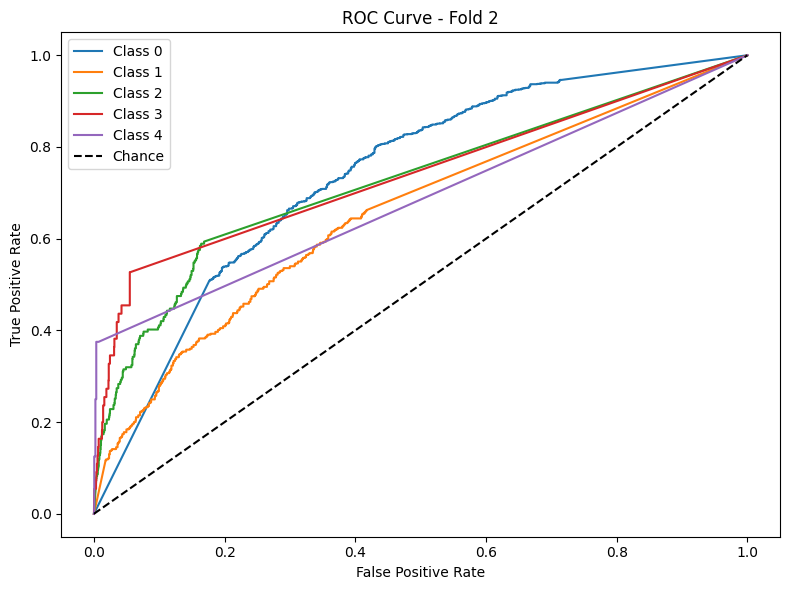


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79      1489
           1       0.38      0.33      0.35       489
           2       0.43      0.36      0.39       219
           3       0.19      0.17      0.18        54
           4       0.25      0.25      0.25         8

    accuracy                           0.65      2259
   macro avg       0.40      0.38      0.39      2259
weighted avg       0.63      0.65      0.64      2259



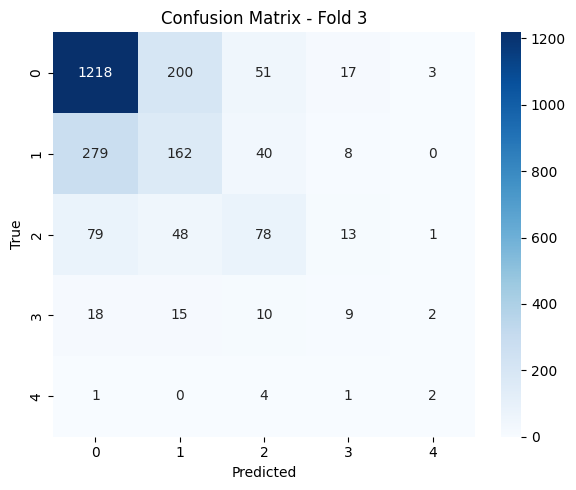

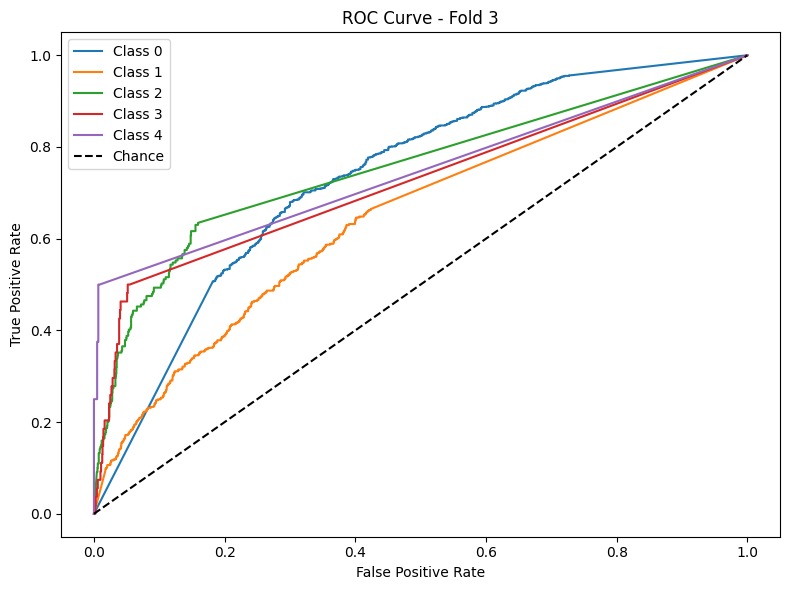


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.82      0.80      1489
           1       0.42      0.36      0.39       489
           2       0.36      0.32      0.34       219
           3       0.28      0.24      0.26        54
           4       0.33      0.50      0.40         8

    accuracy                           0.66      2259
   macro avg       0.43      0.45      0.44      2259
weighted avg       0.64      0.66      0.65      2259



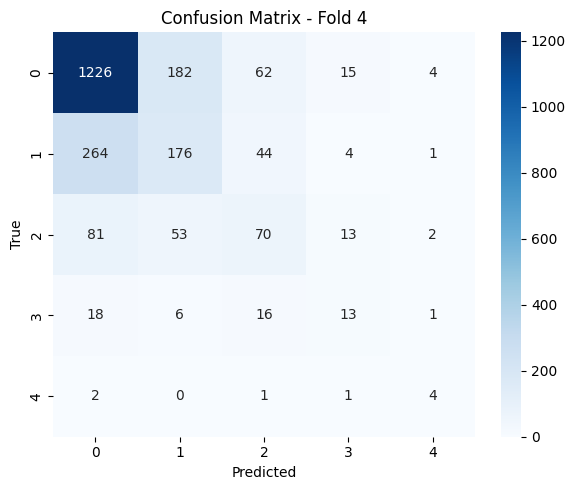

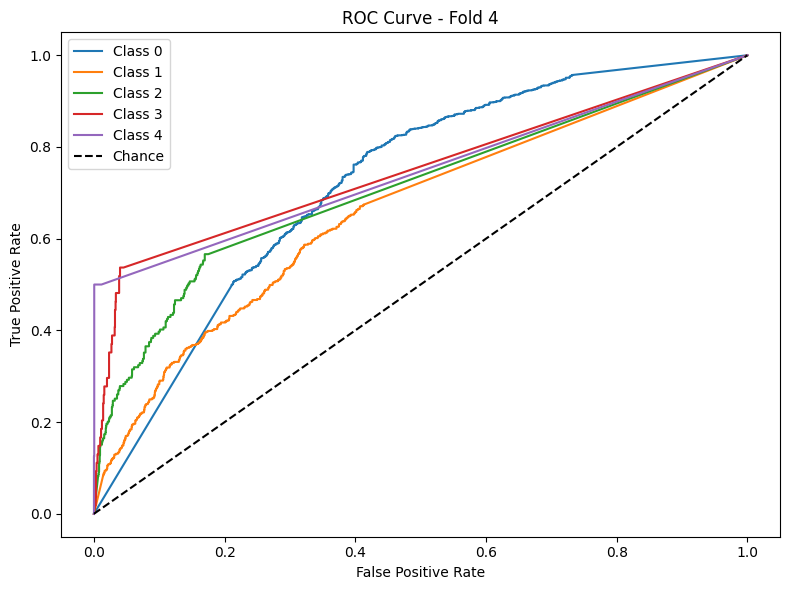


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80      1490
           1       0.39      0.33      0.36       488
           2       0.36      0.37      0.36       219
           3       0.13      0.11      0.12        54
           4       0.14      0.12      0.13         8

    accuracy                           0.65      2259
   macro avg       0.36      0.35      0.36      2259
weighted avg       0.64      0.65      0.64      2259



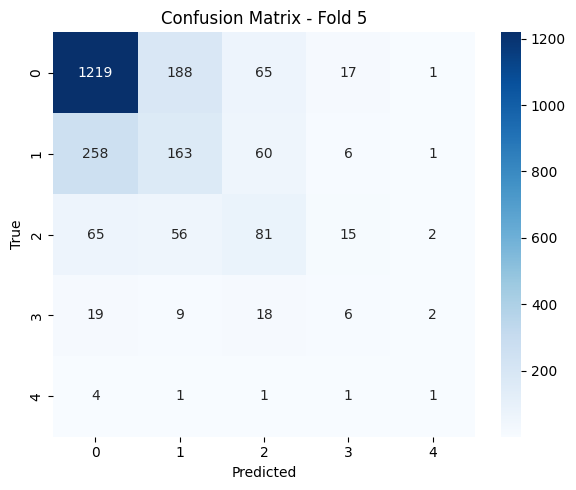

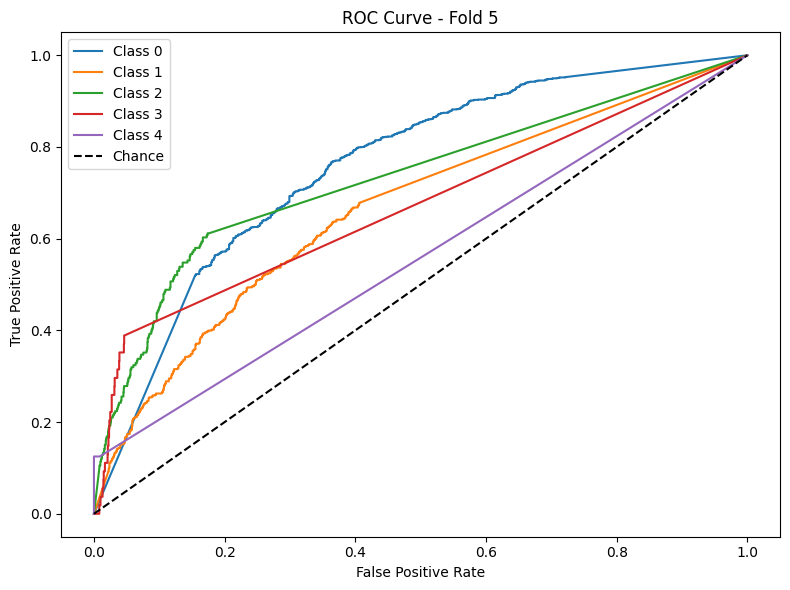


Average Accuracy: 0.6536
Average F1 Macro: 0.3936
Average AUC: 0.7059


============== Training Phase 3 ===============

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'weights': 'distance', 'p': 1, 'n_neighbors': 11, 'algorithm': 'ball_tree'}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.89      0.82      1361
           1       0.47      0.30      0.37       459
           2       0.44      0.34      0.38       198
           3       0.30      0.22      0.26        49
           4       0.00      0.00      0.00         7

    accuracy                           0.69      2074
   macro avg       0.39      0.35      0.37      2074
weighted avg       0.65      0.69      0.66      2074



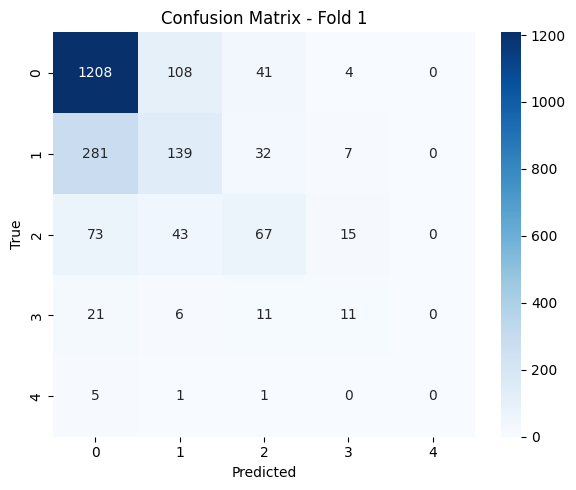

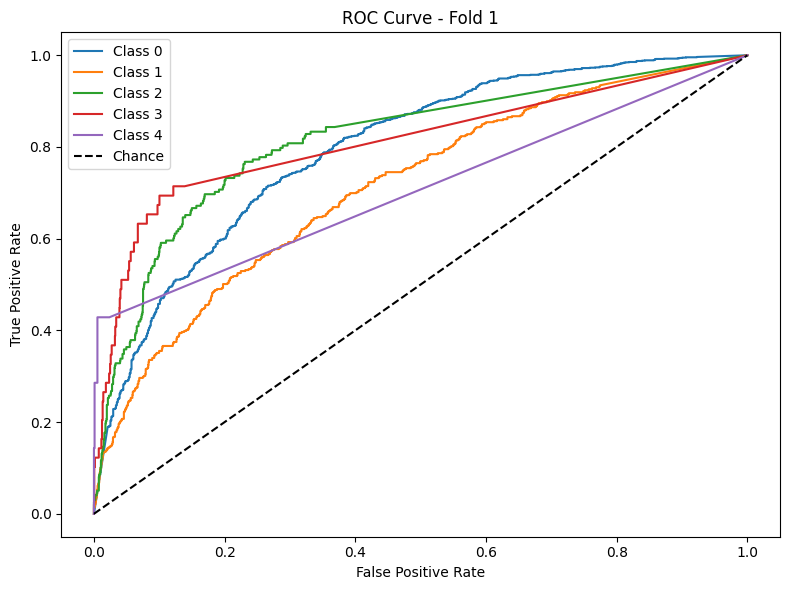


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.87      0.81      1360
           1       0.47      0.33      0.39       459
           2       0.42      0.34      0.38       198
           3       0.40      0.34      0.37        50
           4       0.20      0.14      0.17         7

    accuracy                           0.68      2074
   macro avg       0.45      0.40      0.42      2074
weighted avg       0.66      0.68      0.66      2074



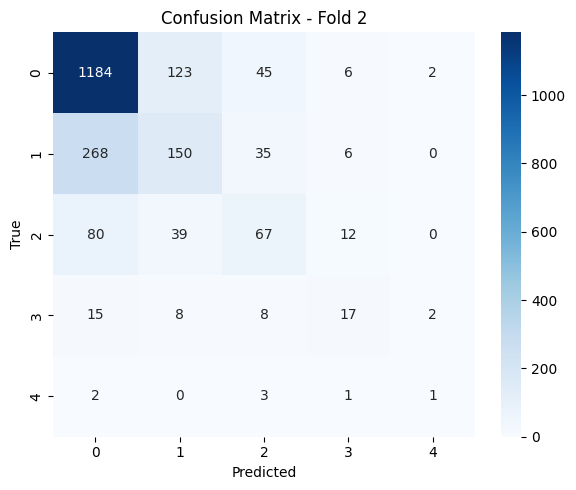

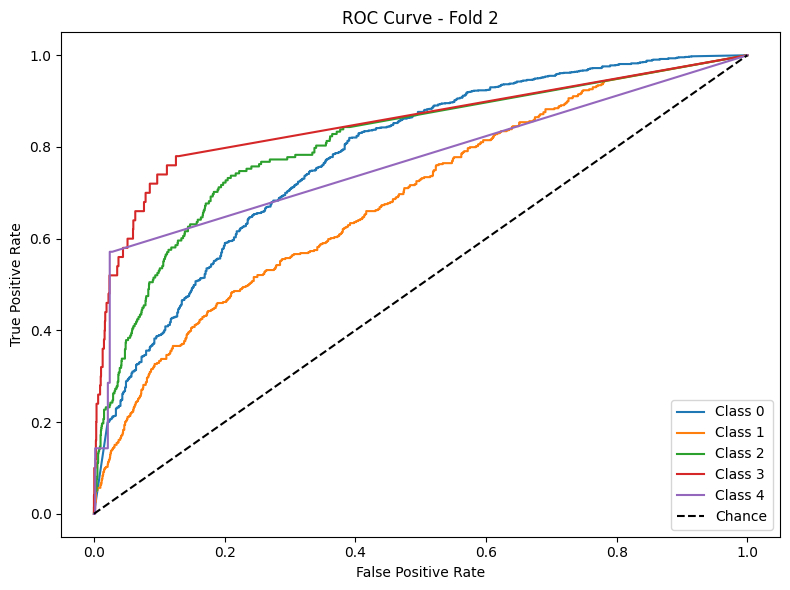


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.89      0.82      1360
           1       0.48      0.29      0.36       459
           2       0.40      0.36      0.38       198
           3       0.46      0.36      0.40        50
           4       0.50      0.14      0.22         7

    accuracy                           0.69      2074
   macro avg       0.52      0.41      0.44      2074
weighted avg       0.66      0.69      0.67      2074



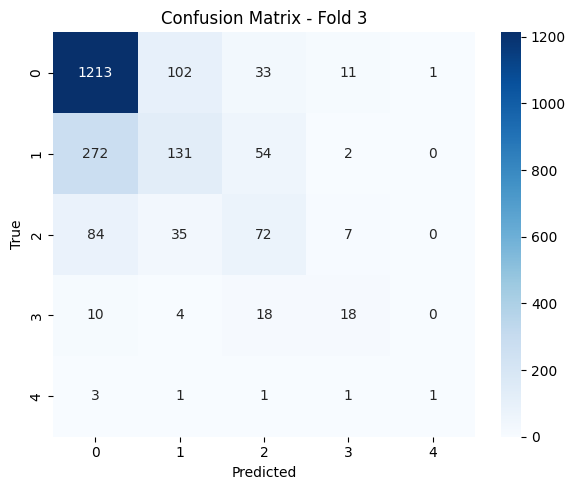

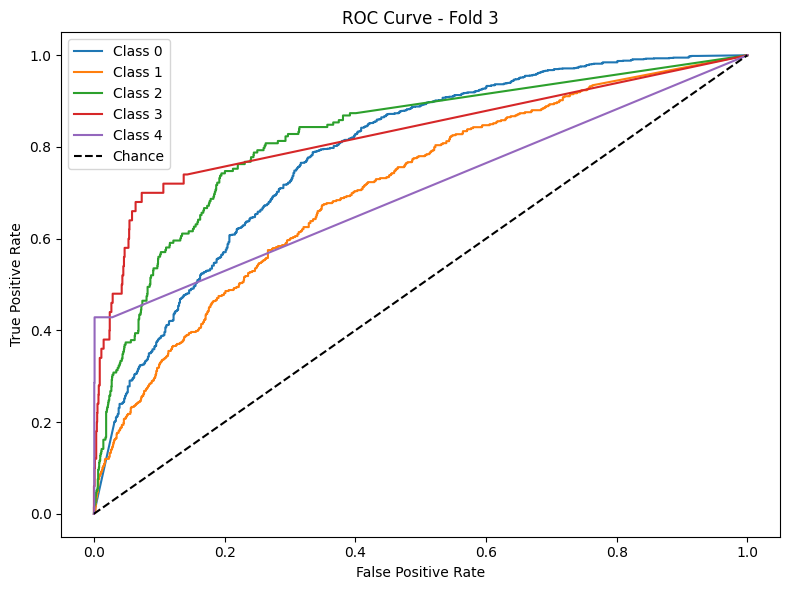


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.87      0.81      1360
           1       0.44      0.31      0.36       459
           2       0.50      0.33      0.40       198
           3       0.41      0.26      0.32        50
           4       0.00      0.00      0.00         7

    accuracy                           0.68      2074
   macro avg       0.42      0.35      0.38      2074
weighted avg       0.65      0.68      0.65      2074



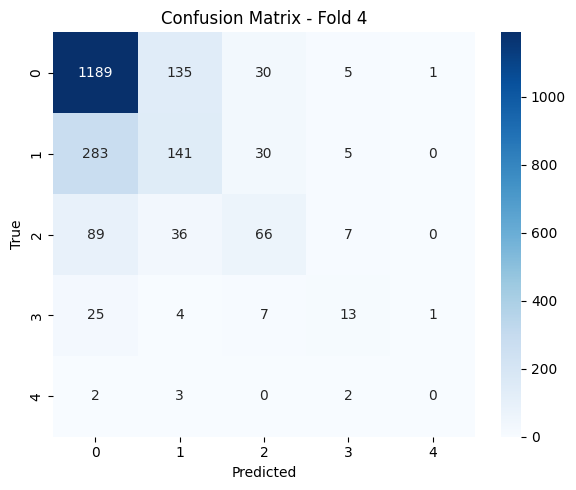

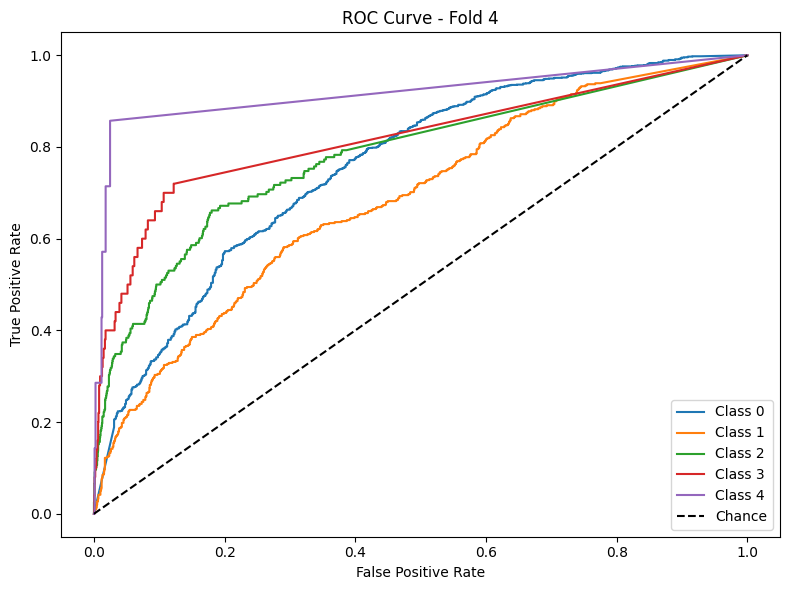


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.87      0.81      1360
           1       0.44      0.31      0.36       460
           2       0.45      0.38      0.41       197
           3       0.35      0.22      0.27        49
           4       0.25      0.14      0.18         7

    accuracy                           0.68      2073
   macro avg       0.45      0.38      0.41      2073
weighted avg       0.65      0.68      0.66      2073



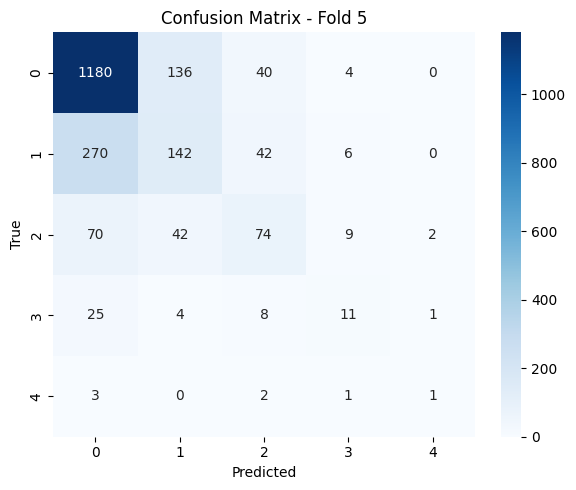

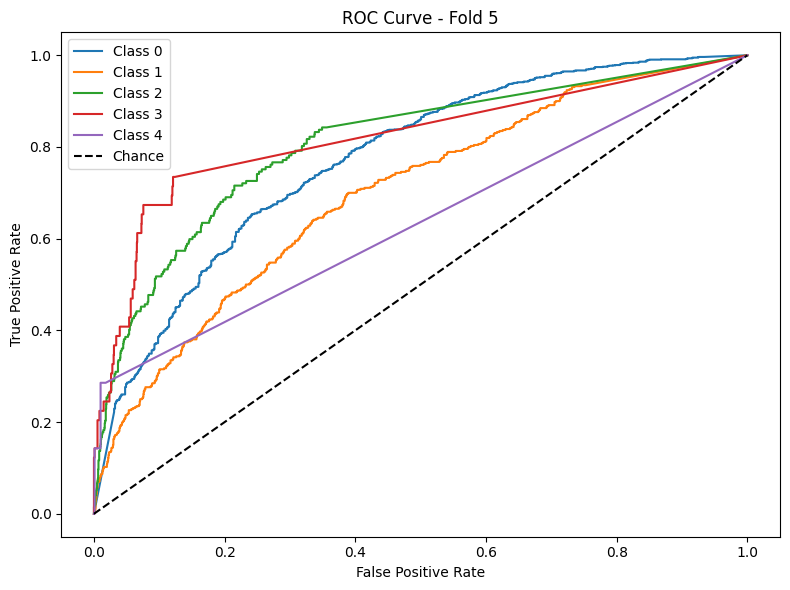


Average Accuracy: 0.6843
Average F1 Macro: 0.4021
Average AUC: 0.7716


============== Training Phase 4 ===============

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'weights': 'distance', 'p': 1, 'n_neighbors': 11, 'algorithm': 'kd_tree'}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.89      0.82      1000
           1       0.51      0.33      0.40       355
           2       0.40      0.30      0.35       139
           3       0.44      0.31      0.36        39
           4       0.00      0.00      0.00         6

    accuracy                           0.69      1539
   macro avg       0.42      0.37      0.39      1539
weighted avg       0.66      0.69      0.66      1539



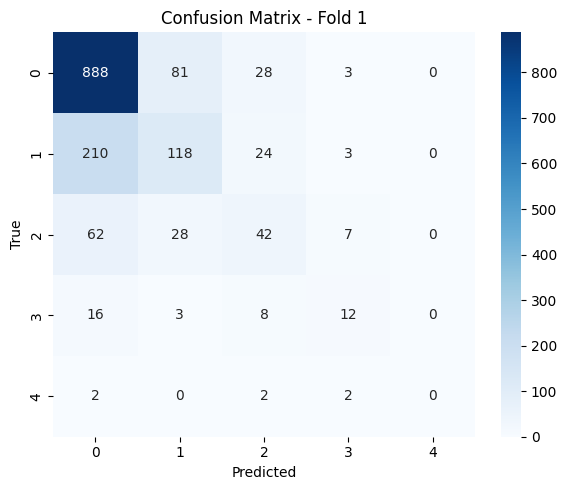

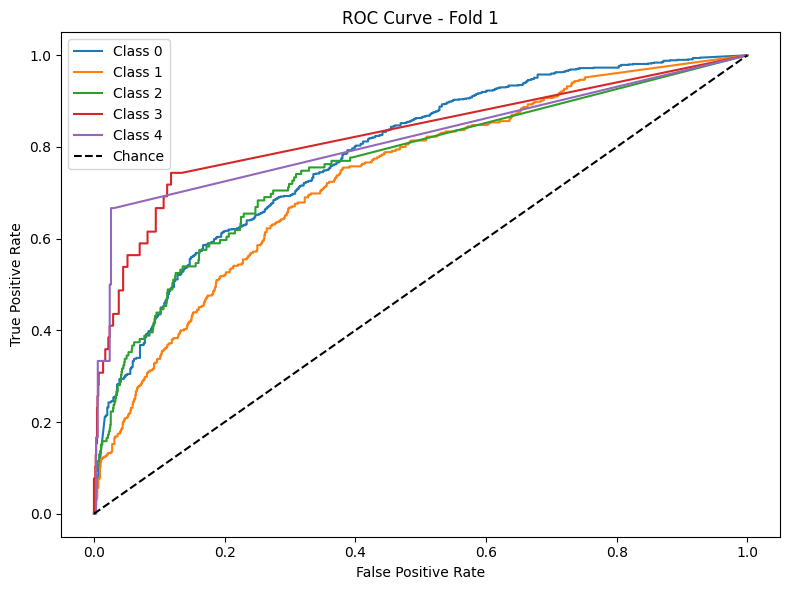


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.88      0.82      1000
           1       0.51      0.32      0.40       355
           2       0.50      0.41      0.45       139
           3       0.48      0.38      0.42        40
           4       0.00      0.00      0.00         5

    accuracy                           0.69      1539
   macro avg       0.45      0.40      0.42      1539
weighted avg       0.67      0.69      0.67      1539



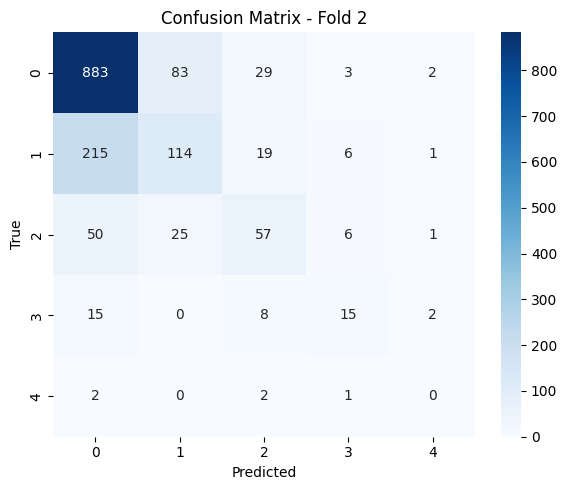

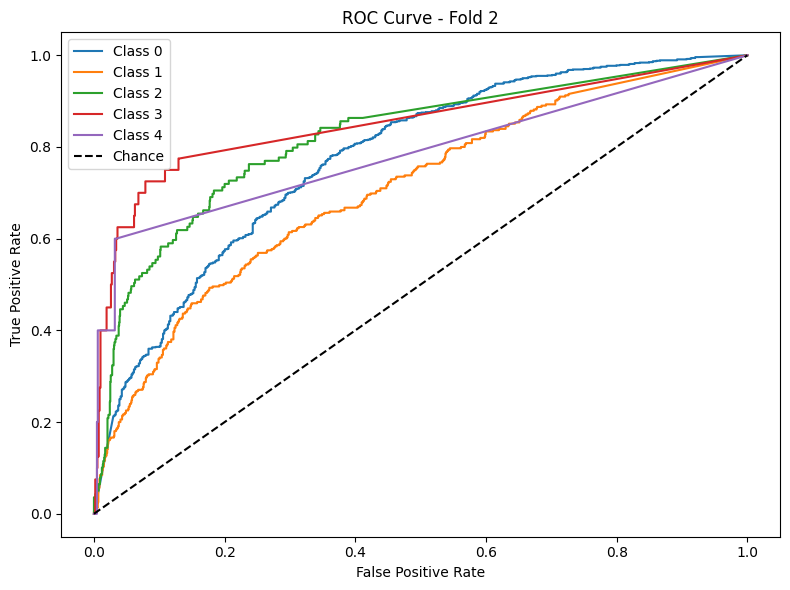


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.89      0.82       999
           1       0.50      0.34      0.40       355
           2       0.52      0.32      0.39       139
           3       0.45      0.38      0.41        40
           4       0.50      0.17      0.25         6

    accuracy                           0.70      1539
   macro avg       0.55      0.42      0.46      1539
weighted avg       0.67      0.70      0.67      1539



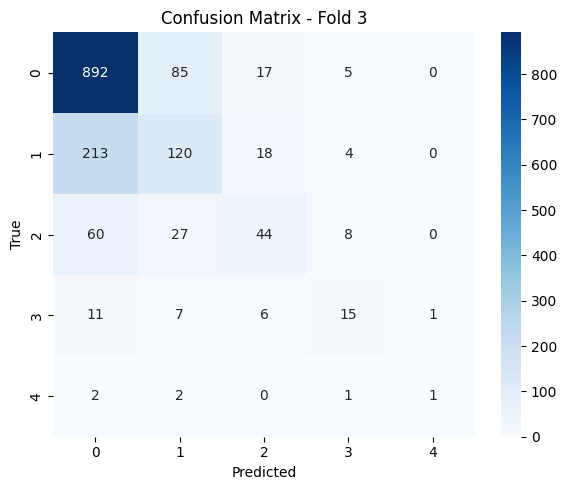

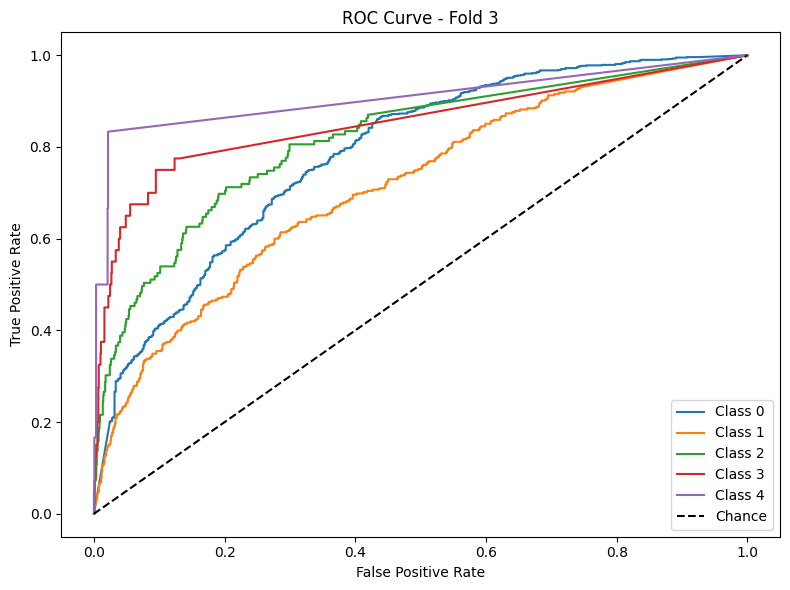

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.91      0.83       999
           1       0.54      0.32      0.40       356
           2       0.49      0.36      0.41       138
           3       0.26      0.23      0.25        39
           4       0.00      0.00      0.00         6

    accuracy                           0.70      1538
   macro avg       0.41      0.36      0.38      1538
weighted avg       0.67      0.70      0.67      1538



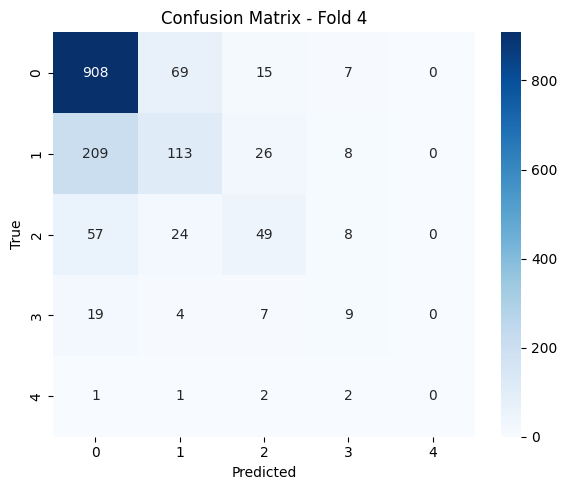

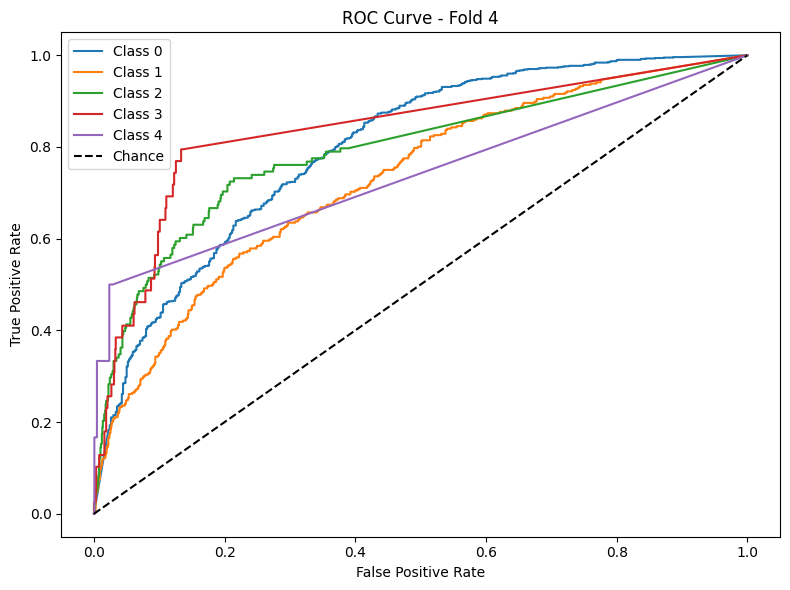


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.89      0.82       999
           1       0.55      0.36      0.43       356
           2       0.38      0.33      0.35       138
           3       0.47      0.44      0.45        39
           4       0.50      0.17      0.25         6

    accuracy                           0.70      1538
   macro avg       0.53      0.43      0.46      1538
weighted avg       0.67      0.70      0.68      1538



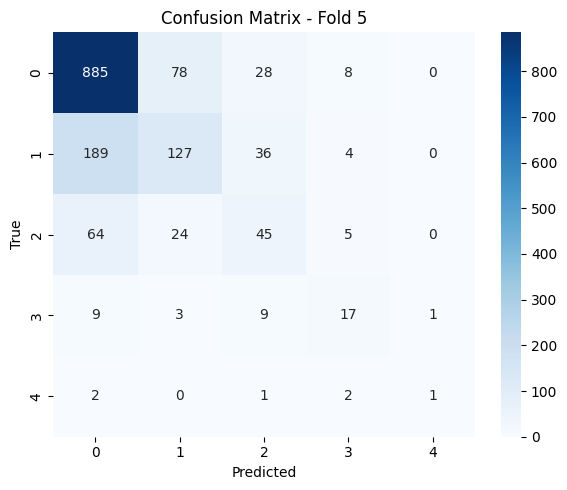

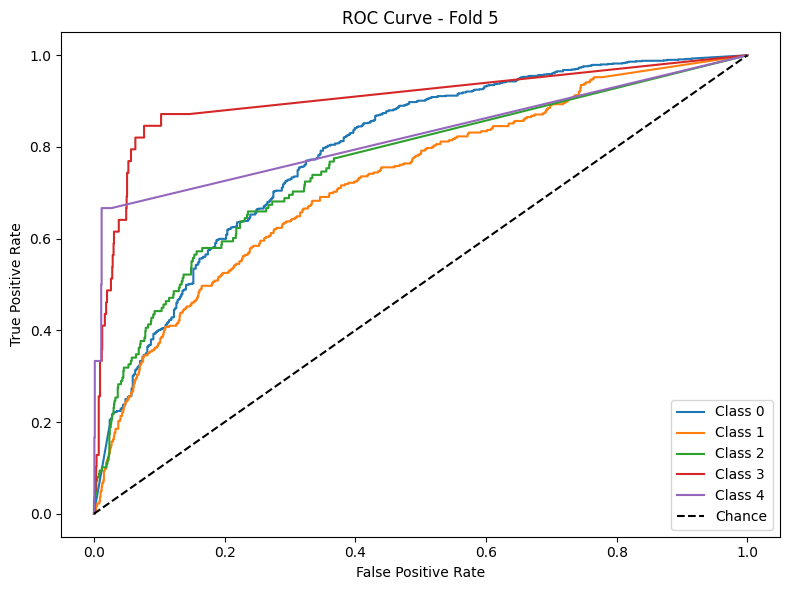


Average Accuracy: 0.6961
Average F1 Macro: 0.4193
Average AUC: 0.7933


In [5]:
phase_paths = [f"/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n================================================")
    print(f"\n============== Training Phase {i} ===============")
    print(f"\n=================================================")
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics


## Predict on Test Data

In [6]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

def predict_on_test(test_file_path, model_file, scaler_file, school_mapping_file):
    # Load model, scaler, and mapping
    model = joblib.load(model_file)
    scaler = joblib.load(scaler_file)
    mapping = joblib.load(school_mapping_file)

    # Load and preprocess test data
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded']
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    # Apply school mapping
    if 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    # Scale features
    X_test_scaled = scaler.transform(X_test)

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score
    classes = model.classes_
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred


Classification Report:



/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.87      0.92      0.89       568
           1       0.23      0.24      0.23        63
           2       0.29      0.16      0.21        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.78       698
   macro avg       0.28      0.26      0.27       698
weighted avg       0.74      0.78      0.76       698



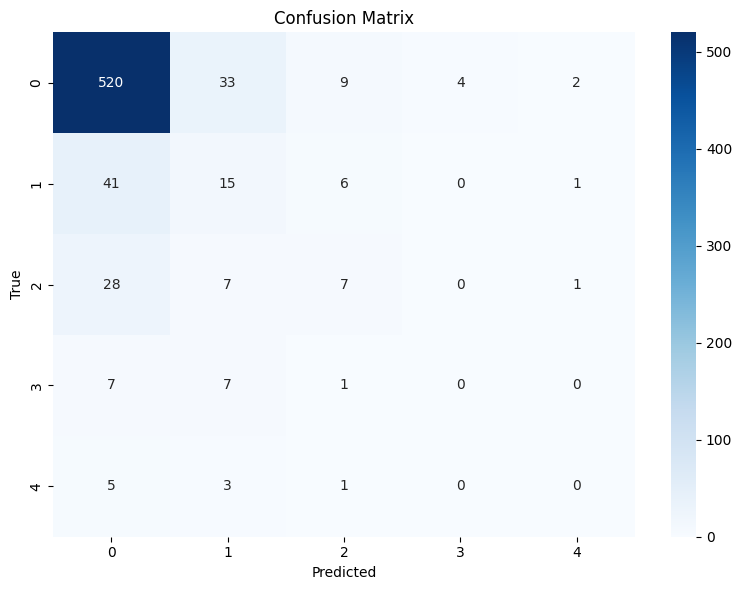


Test AUC (macro-average, OVR): 0.5575


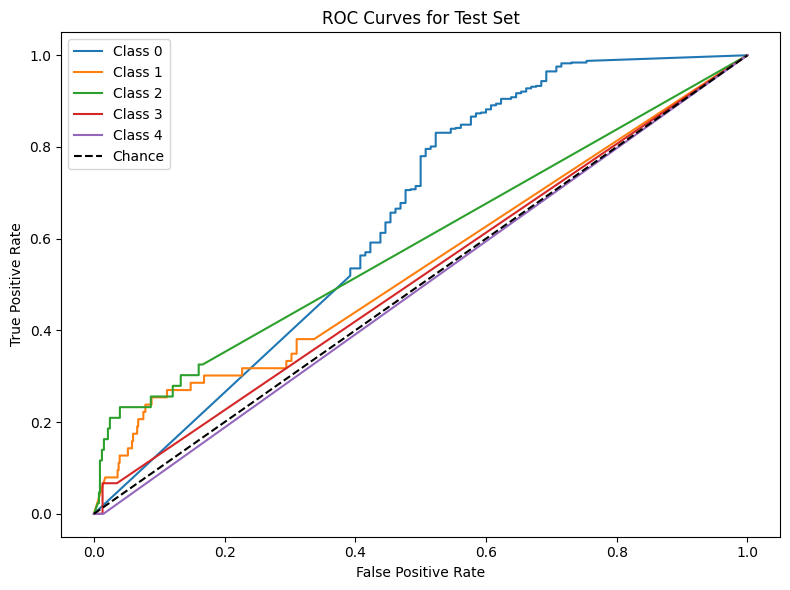

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       544
           1       0.16      0.15      0.16        59
           2       0.17      0.14      0.15        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.75       668
   macro avg       0.24      0.24      0.24       668
weighted avg       0.72      0.75      0.74       668



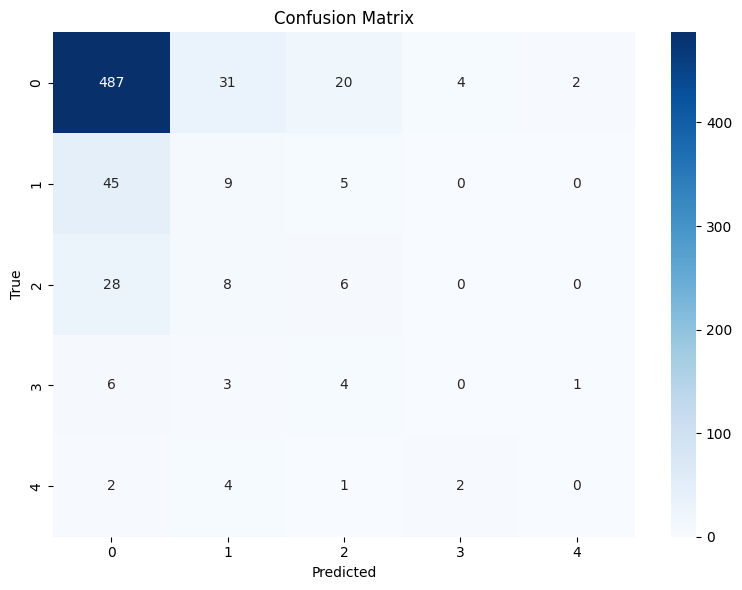


Test AUC (macro-average, OVR): 0.5719


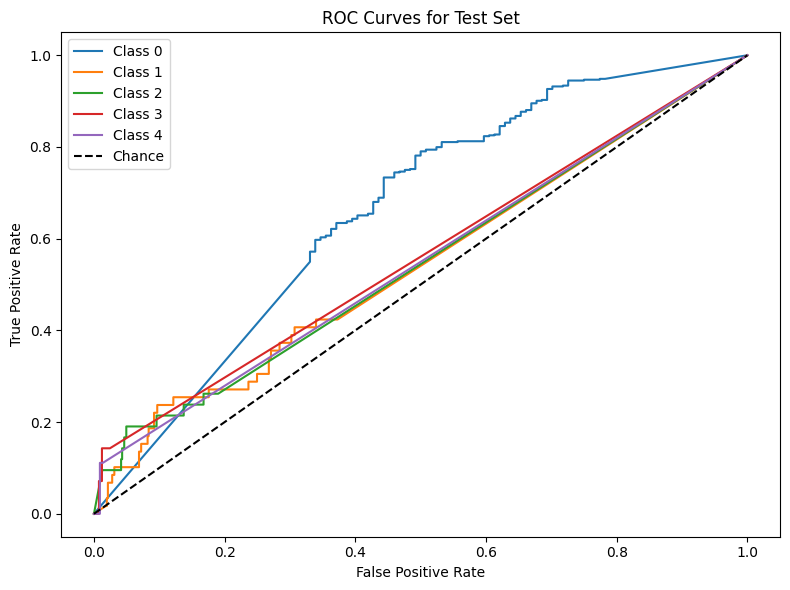

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       455
           1       0.10      0.04      0.05        52
           2       0.17      0.21      0.18        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.78       554
   macro avg       0.22      0.24      0.23       554
weighted avg       0.72      0.78      0.75       554



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


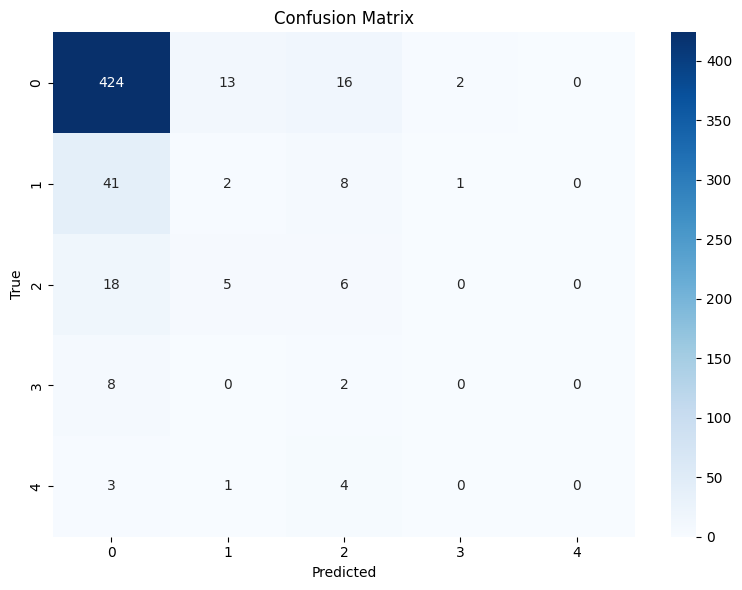


Test AUC (macro-average, OVR): 0.6382


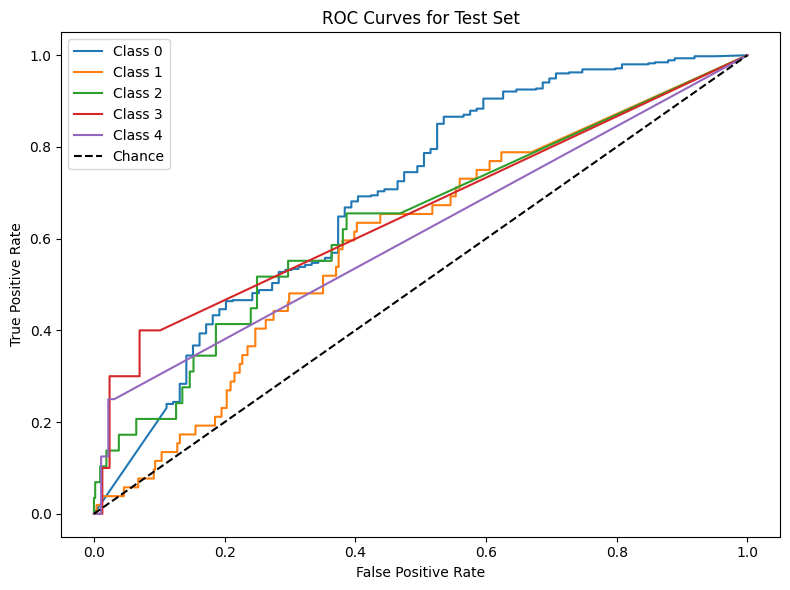

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.81      0.83       395
           1       0.13      0.07      0.10        40
           2       0.09      0.29      0.14        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.69       477
   macro avg       0.22      0.24      0.21       477
weighted avg       0.73      0.69      0.71       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


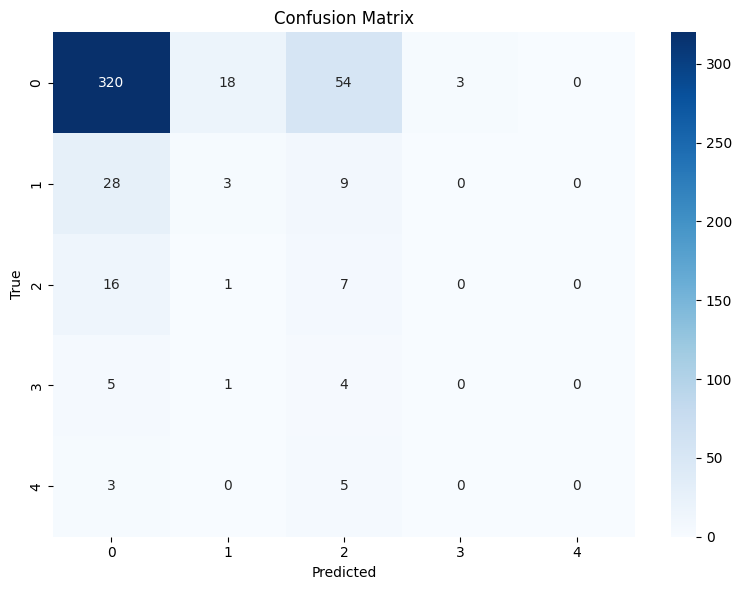


Test AUC (macro-average, OVR): 0.6508


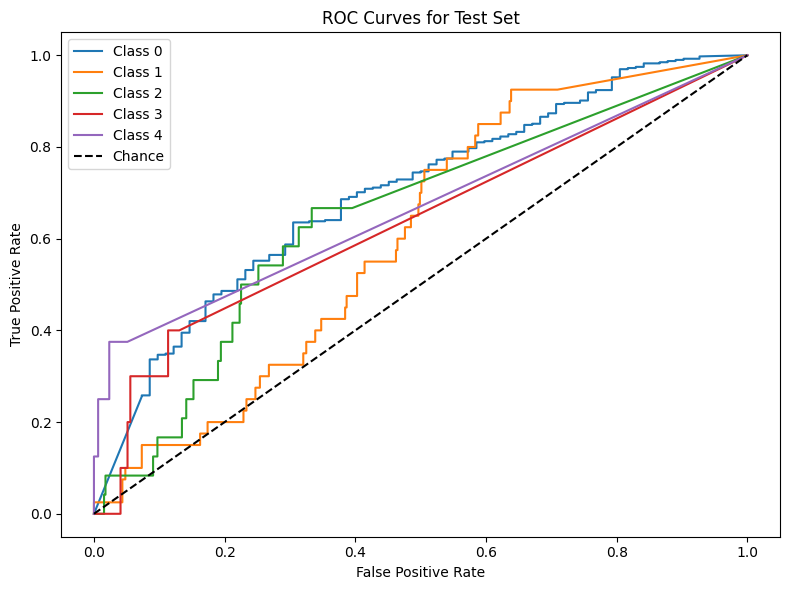

In [7]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-using-node2vector/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)


# Sample


=== Training Phase 1 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'weights': 'distance', 'p': 1, 'n_neighbors': 3, 'algorithm': 'brute'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.68      0.74      1785
           1       0.40      0.48      0.44       604
           2       0.30      0.43      0.35       258
           3       0.19      0.36      0.25        59
           4       0.07      0.11      0.08         9

    accuracy                           0.61      2715
   macro avg       0.35      0.41      0.37      2715
weighted avg       0.66      0.61      0.63      2715



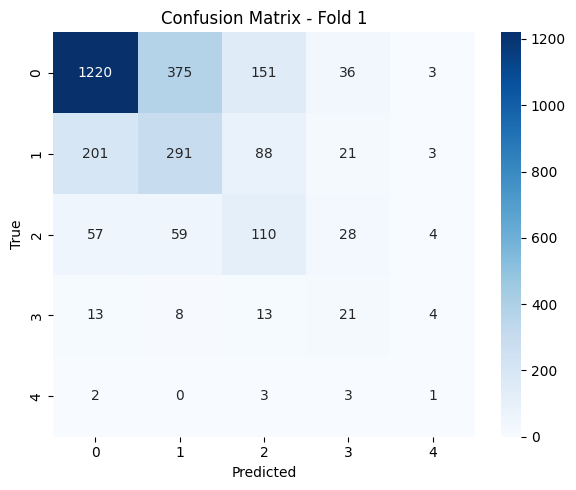

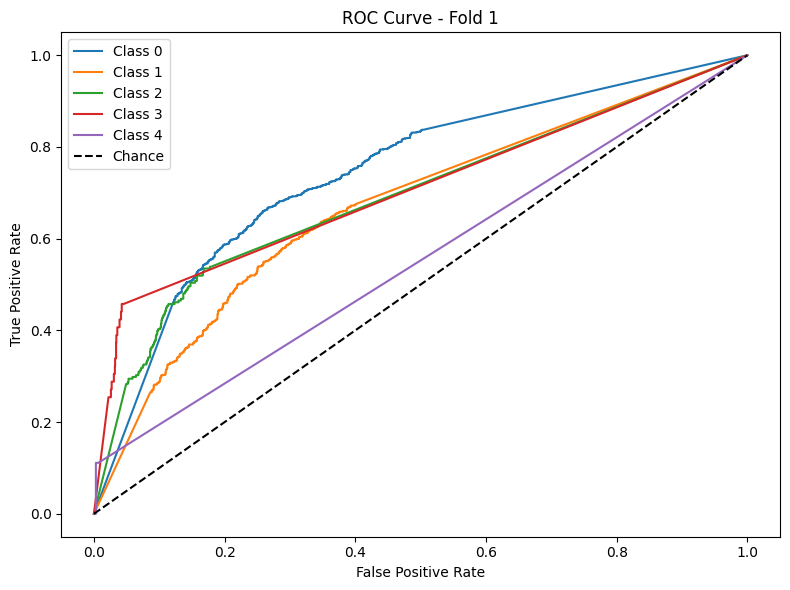


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.68      0.74      1786
           1       0.40      0.48      0.44       603
           2       0.31      0.42      0.36       258
           3       0.24      0.51      0.33        59
           4       0.15      0.25      0.19         8

    accuracy                           0.61      2714
   macro avg       0.38      0.47      0.41      2714
weighted avg       0.66      0.61      0.63      2714



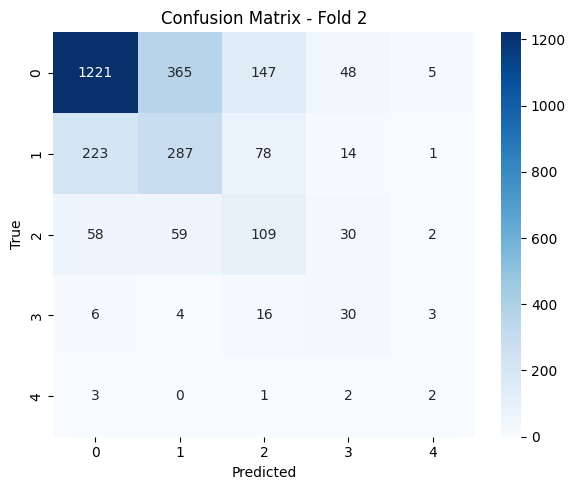

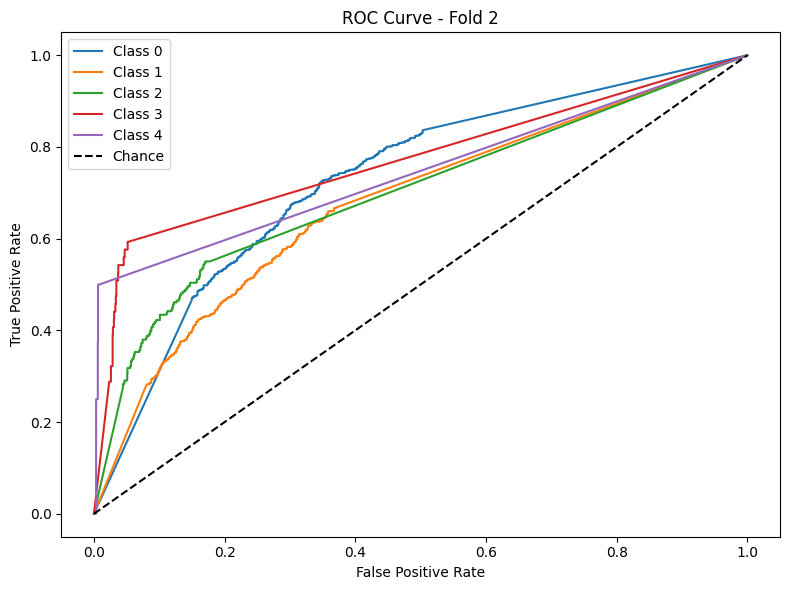


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.69      0.75      1786
           1       0.40      0.49      0.44       603
           2       0.33      0.47      0.39       258
           3       0.22      0.34      0.27        59
           4       0.13      0.38      0.19         8

    accuracy                           0.61      2714
   macro avg       0.38      0.47      0.41      2714
weighted avg       0.66      0.61      0.63      2714



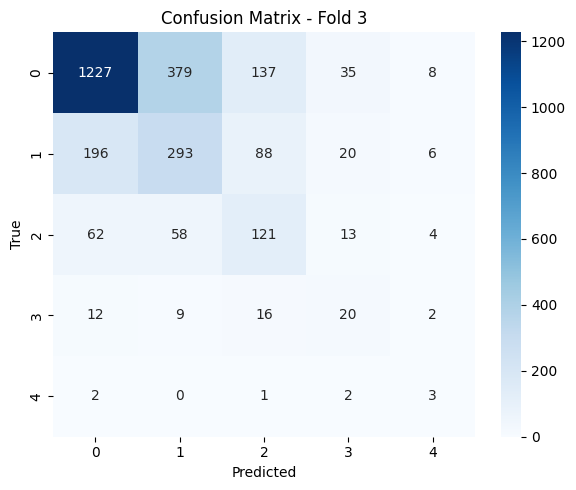

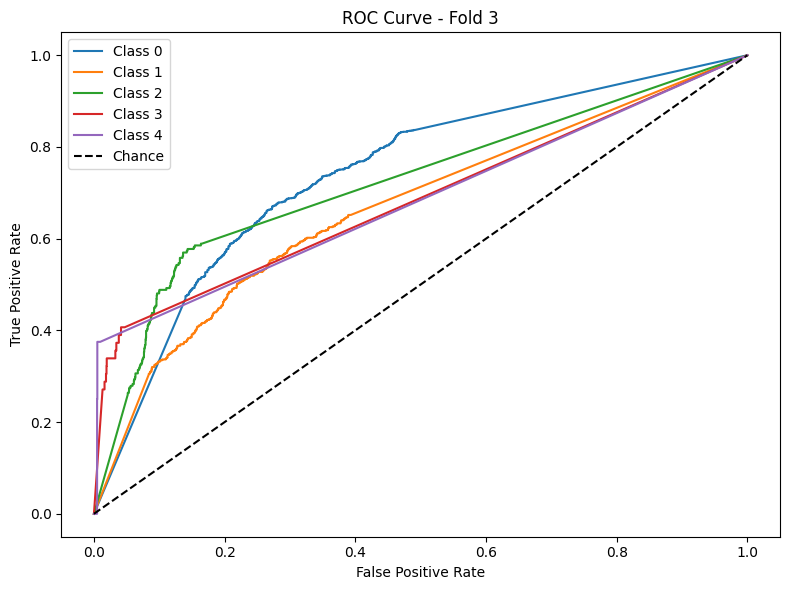


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.69      0.74      1785
           1       0.40      0.50      0.44       603
           2       0.33      0.44      0.38       258
           3       0.19      0.32      0.24        59
           4       0.12      0.11      0.12         9

    accuracy                           0.61      2714
   macro avg       0.37      0.41      0.38      2714
weighted avg       0.66      0.61      0.63      2714



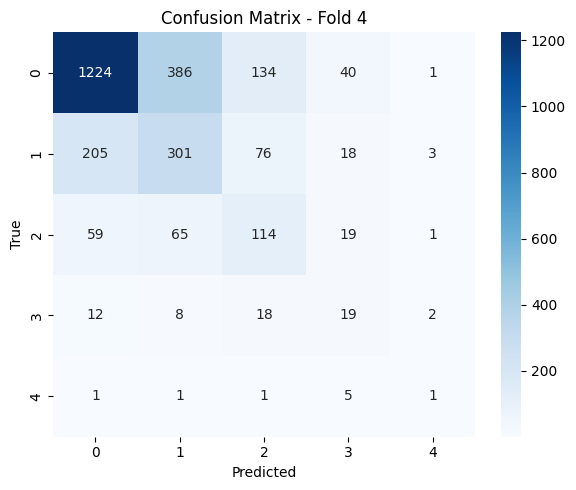

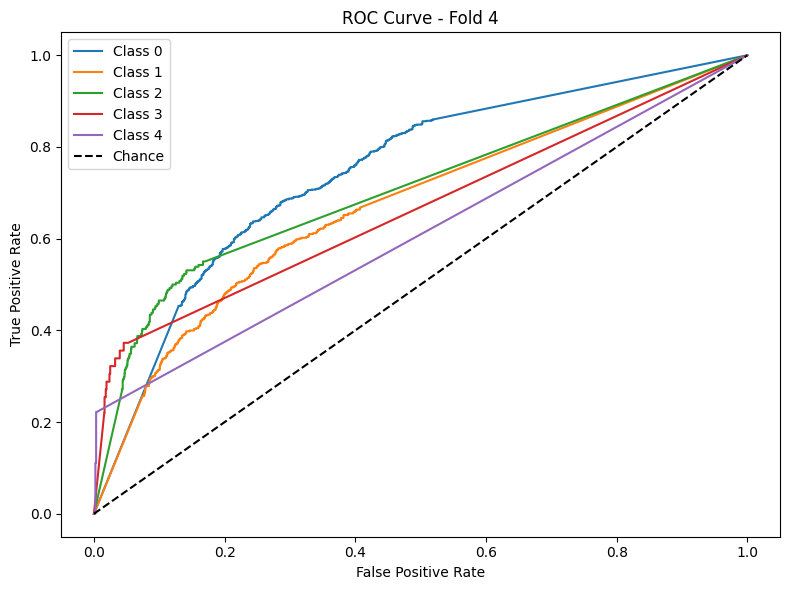


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.69      0.74      1785
           1       0.38      0.46      0.41       603
           2       0.30      0.40      0.34       258
           3       0.17      0.34      0.23        59
           4       0.17      0.11      0.13         9

    accuracy                           0.60      2714
   macro avg       0.36      0.40      0.37      2714
weighted avg       0.65      0.60      0.62      2714



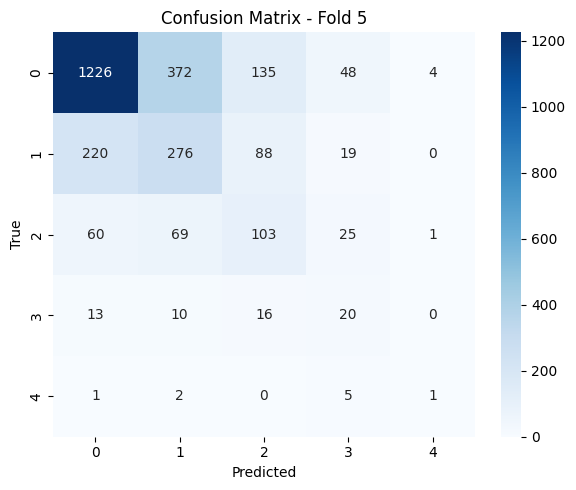

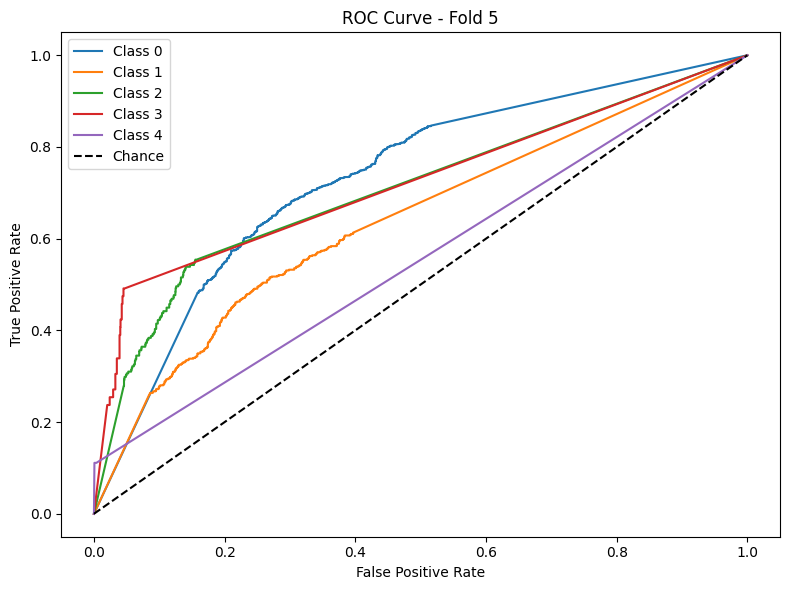


Average Accuracy: 0.6073
Average F1 Macro: 0.3894
Average AUC: 0.6900

=== Training Phase 2 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'weights': 'distance', 'p': 1, 'n_neighbors': 3, 'algorithm': 'auto'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.67      0.74      1489
           1       0.36      0.46      0.40       488
           2       0.27      0.35      0.31       220
           3       0.22      0.44      0.29        54
           4       0.33      0.22      0.27         9

    accuracy                           0.59      2260
   macro avg       0.40      0.43      0.40      2260
weighted avg       0.65      0.59      0.61      2260



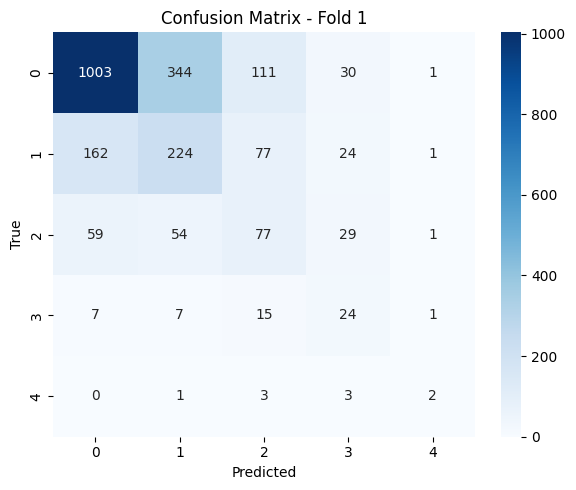

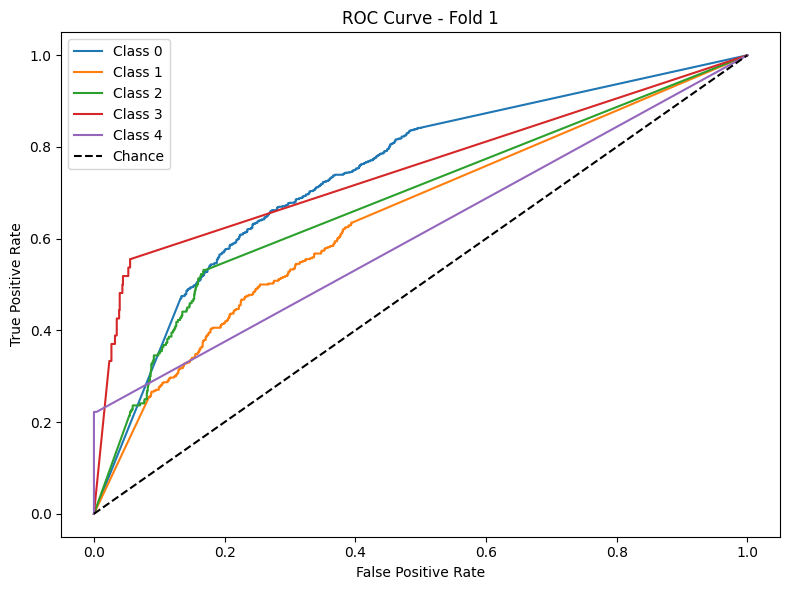


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.67      0.73      1489
           1       0.34      0.41      0.37       489
           2       0.28      0.41      0.34       219
           3       0.24      0.42      0.30        55
           4       0.25      0.25      0.25         8

    accuracy                           0.58      2260
   macro avg       0.38      0.43      0.40      2260
weighted avg       0.64      0.58      0.60      2260



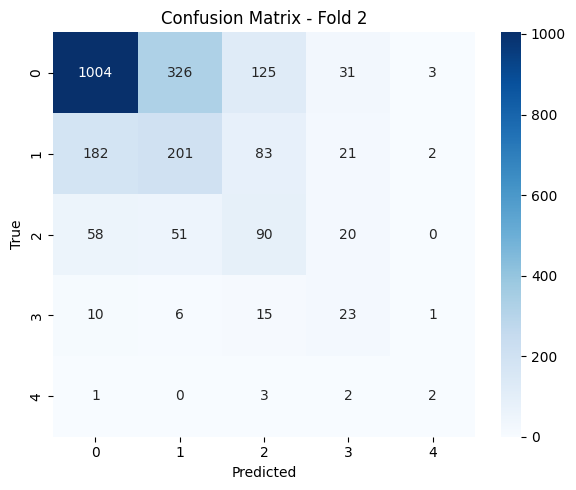

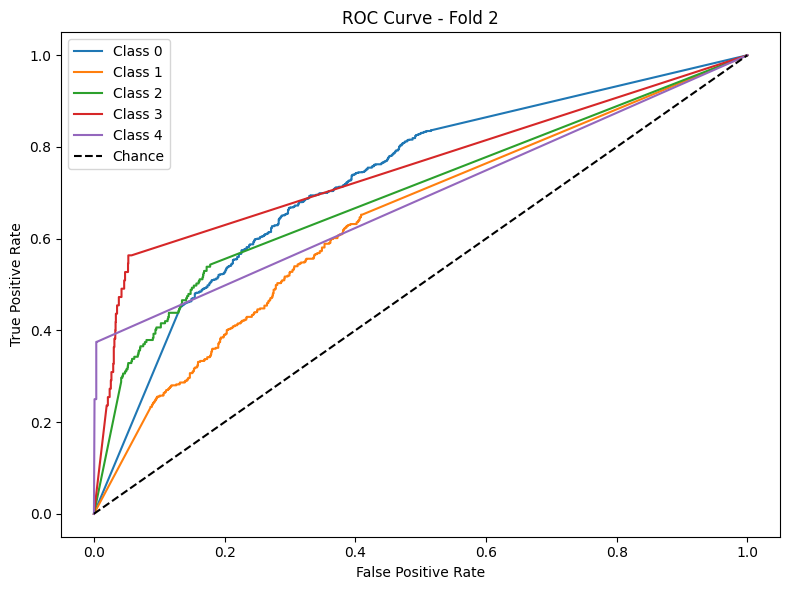


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.68      0.74      1489
           1       0.35      0.43      0.39       489
           2       0.34      0.42      0.38       219
           3       0.18      0.33      0.24        54
           4       0.25      0.50      0.33         8

    accuracy                           0.59      2259
   macro avg       0.39      0.47      0.41      2259
weighted avg       0.64      0.59      0.61      2259



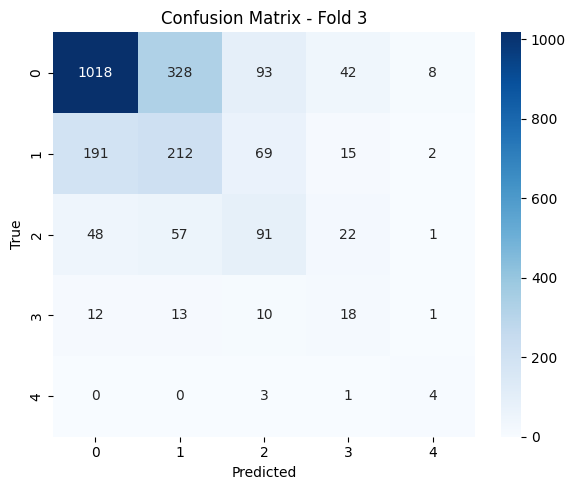

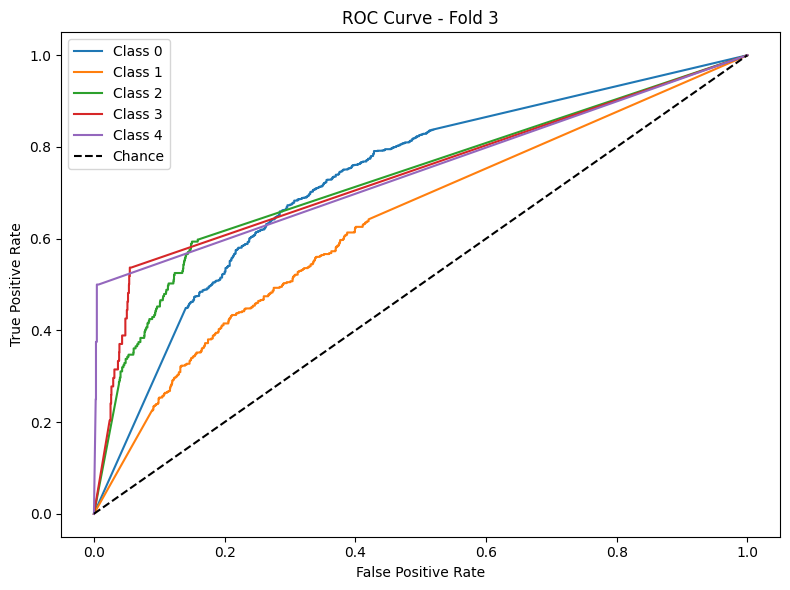


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.69      0.74      1489
           1       0.35      0.41      0.38       489
           2       0.29      0.39      0.33       219
           3       0.24      0.39      0.29        54
           4       0.25      0.50      0.33         8

    accuracy                           0.59      2259
   macro avg       0.38      0.48      0.41      2259
weighted avg       0.63      0.59      0.61      2259



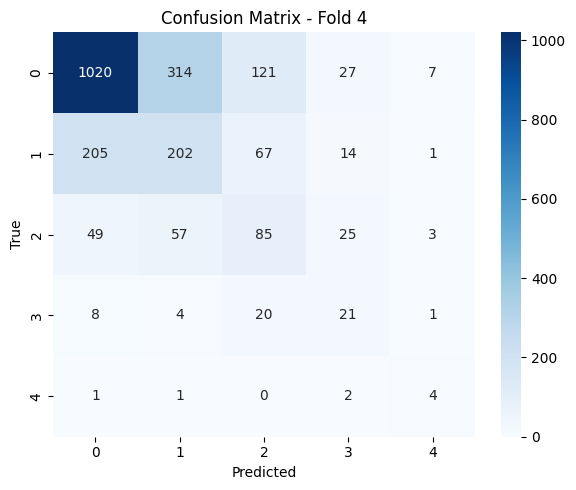

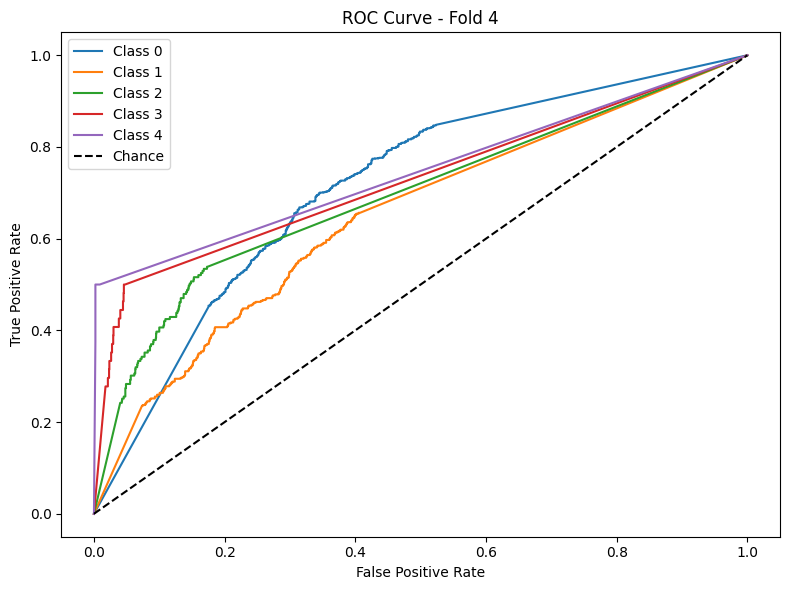


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.69      0.75      1490
           1       0.37      0.46      0.41       488
           2       0.32      0.43      0.37       219
           3       0.19      0.28      0.22        54
           4       0.10      0.12      0.11         8

    accuracy                           0.60      2259
   macro avg       0.36      0.40      0.37      2259
weighted avg       0.65      0.60      0.62      2259



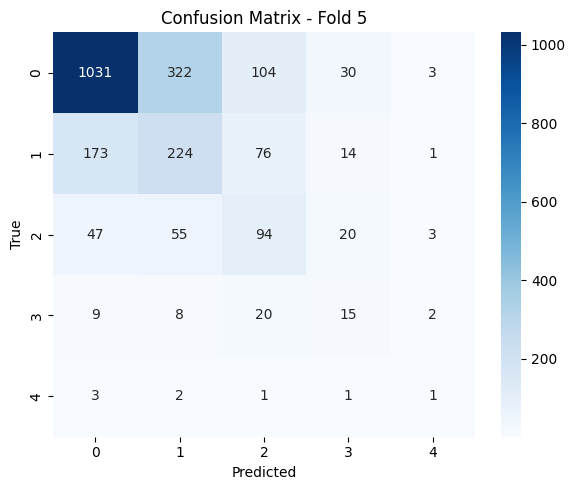

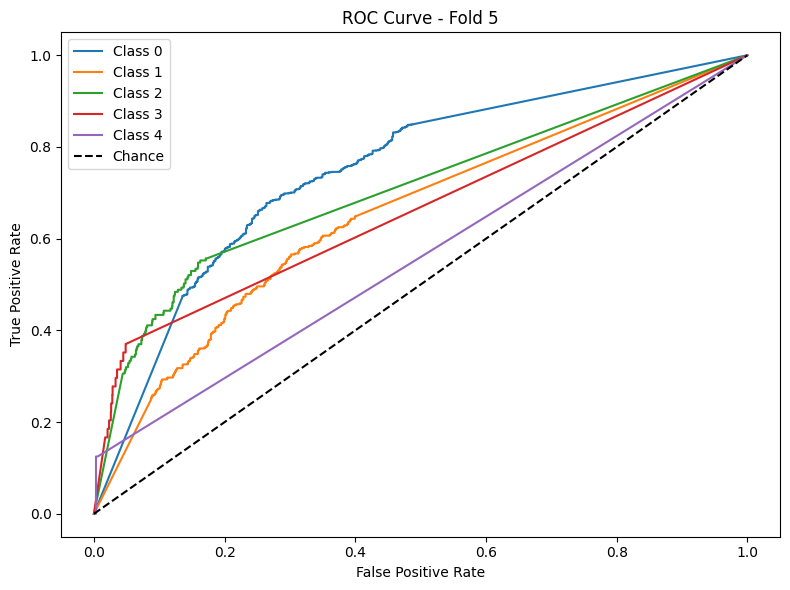


Average Accuracy: 0.5922
Average F1 Macro: 0.4000
Average AUC: 0.6958

=== Training Phase 3 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'weights': 'distance', 'p': 1, 'n_neighbors': 3, 'algorithm': 'auto'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.68      0.74      1361
           1       0.37      0.44      0.40       459
           2       0.30      0.43      0.35       198
           3       0.17      0.31      0.22        49
           4       0.29      0.29      0.29         7

    accuracy                           0.59      2074
   macro avg       0.39      0.43      0.40      2074
weighted avg       0.65      0.59      0.61      2074



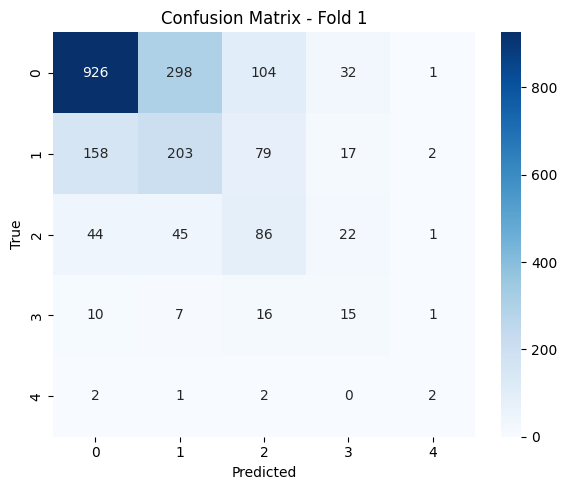

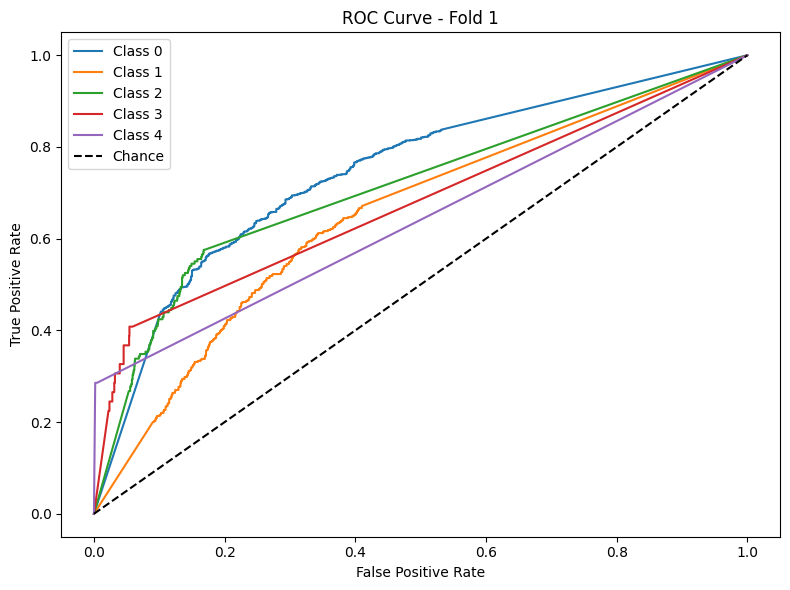


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.71      0.75      1360
           1       0.37      0.45      0.41       459
           2       0.33      0.40      0.37       198
           3       0.22      0.40      0.29        50
           4       0.12      0.14      0.13         7

    accuracy                           0.61      2074
   macro avg       0.37      0.42      0.39      2074
weighted avg       0.65      0.61      0.63      2074



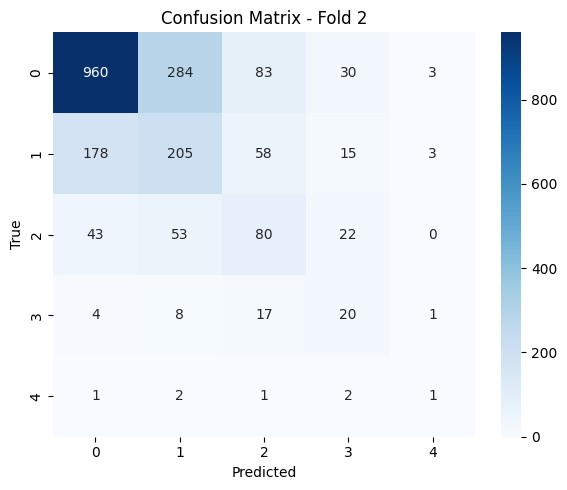

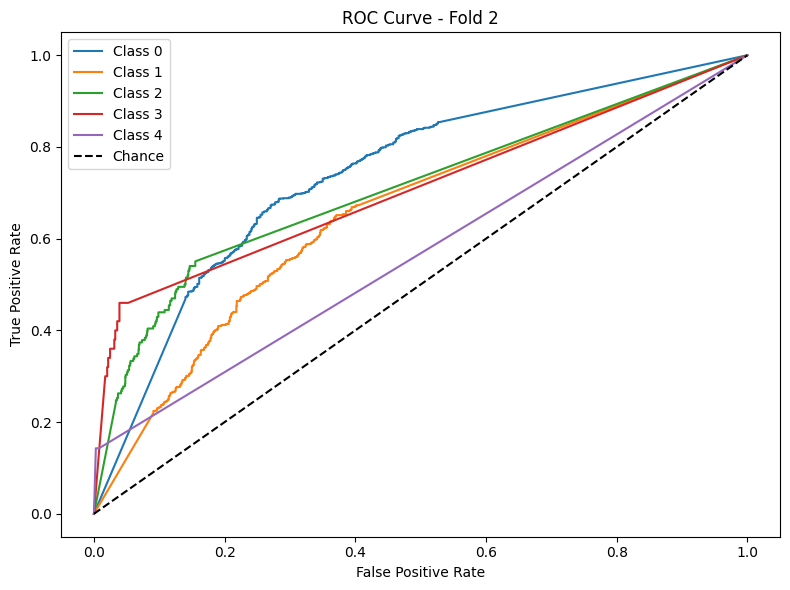


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.69      0.74      1360
           1       0.35      0.40      0.37       459
           2       0.29      0.39      0.33       198
           3       0.19      0.32      0.24        50
           4       0.15      0.29      0.20         7

    accuracy                           0.59      2074
   macro avg       0.35      0.42      0.38      2074
weighted avg       0.63      0.59      0.61      2074



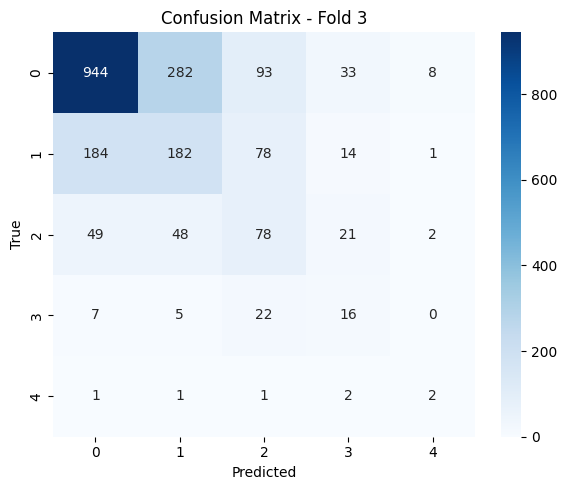

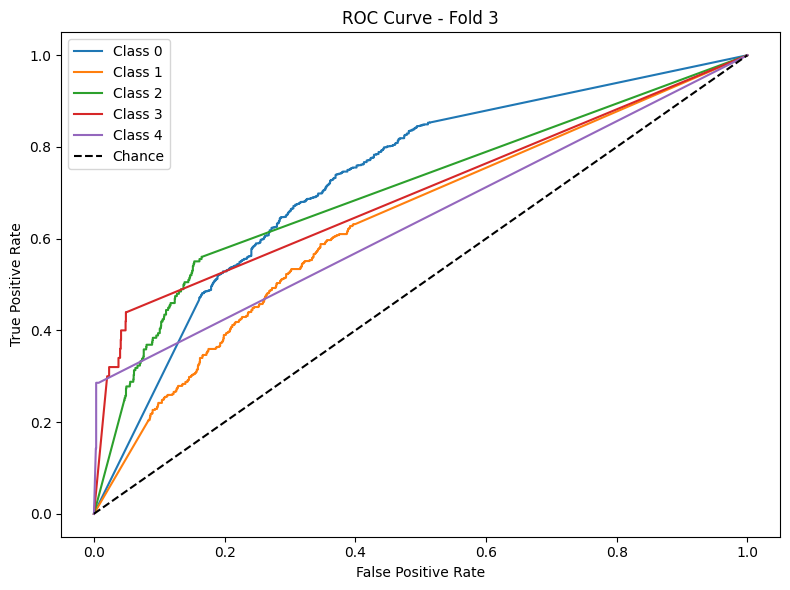


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.66      0.72      1360
           1       0.33      0.41      0.37       459
           2       0.29      0.36      0.32       198
           3       0.21      0.36      0.27        50
           4       0.09      0.14      0.11         7

    accuracy                           0.57      2074
   macro avg       0.34      0.39      0.36      2074
weighted avg       0.62      0.57      0.59      2074



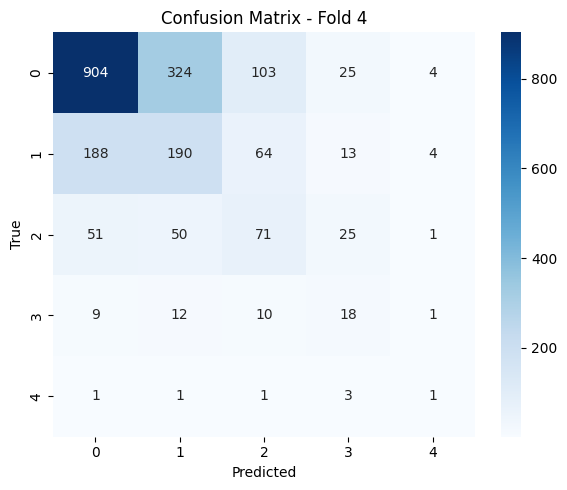

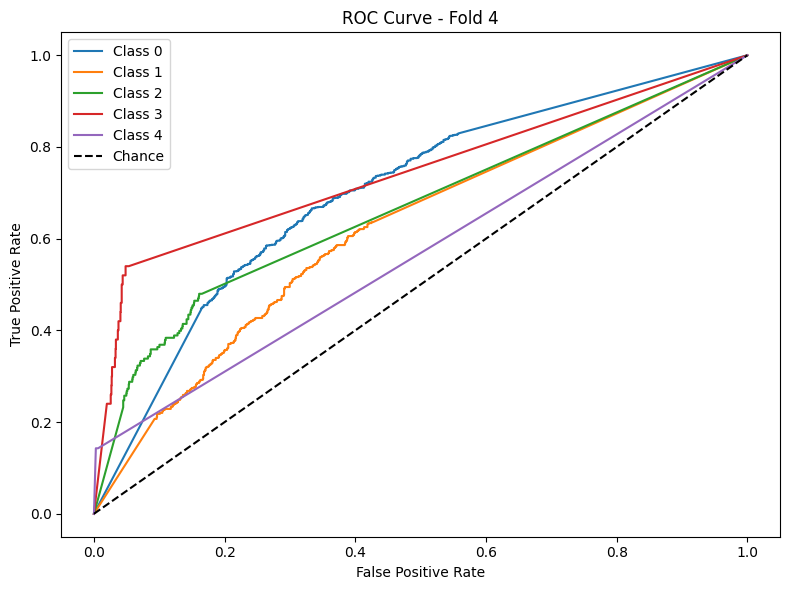


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.69      0.73      1360
           1       0.35      0.43      0.38       460
           2       0.32      0.39      0.35       197
           3       0.22      0.33      0.26        49
           4       0.12      0.14      0.13         7

    accuracy                           0.59      2073
   macro avg       0.36      0.39      0.37      2073
weighted avg       0.63      0.59      0.61      2073



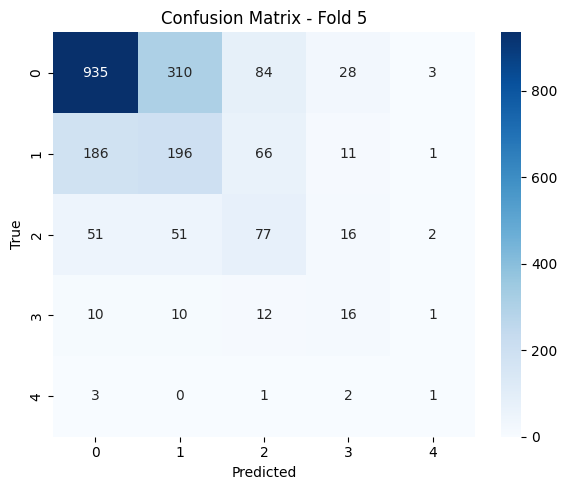

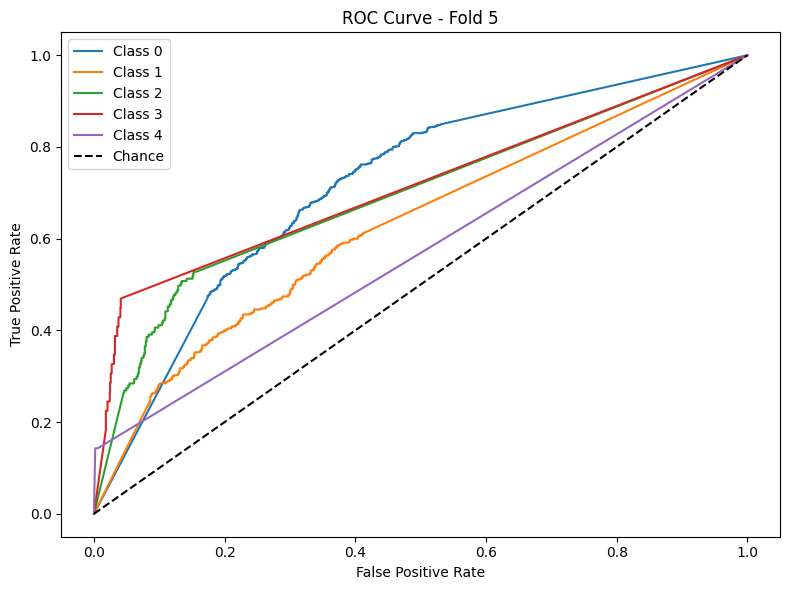


Average Accuracy: 0.5911
Average F1 Macro: 0.3792
Average AUC: 0.6740

=== Training Phase 4 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'weights': 'distance', 'p': 1, 'n_neighbors': 3, 'algorithm': 'brute'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.70      0.74      1000
           1       0.40      0.46      0.43       355
           2       0.27      0.37      0.31       139
           3       0.20      0.28      0.23        39
           4       0.08      0.17      0.11         6

    accuracy                           0.60      1539
   macro avg       0.35      0.39      0.36      1539
weighted avg       0.64      0.60      0.62      1539



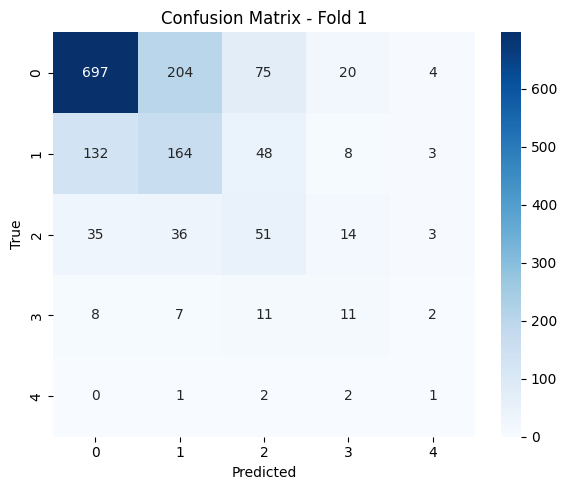

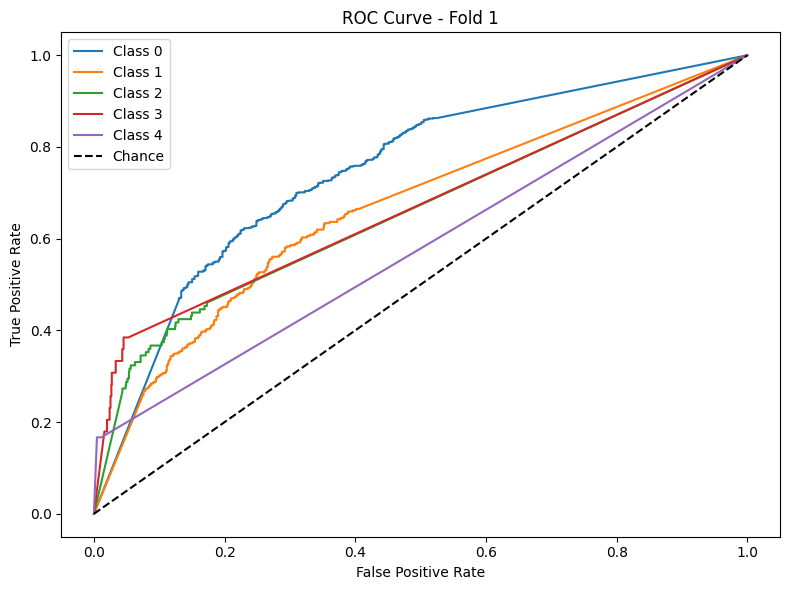


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.69      0.74      1000
           1       0.40      0.47      0.43       355
           2       0.34      0.47      0.40       139
           3       0.26      0.42      0.32        40
           4       0.15      0.40      0.22         5

    accuracy                           0.61      1539
   macro avg       0.39      0.49      0.42      1539
weighted avg       0.66      0.61      0.63      1539



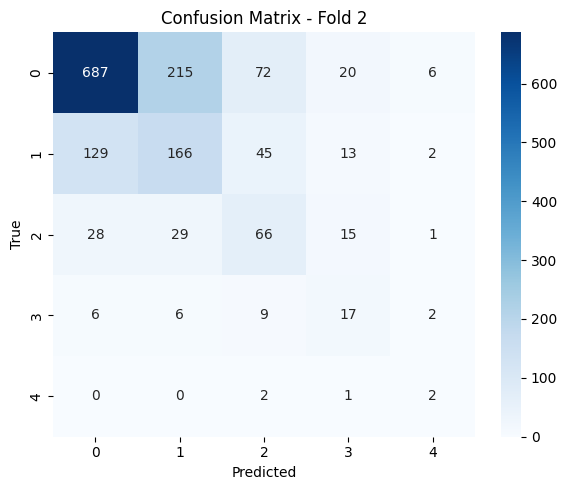

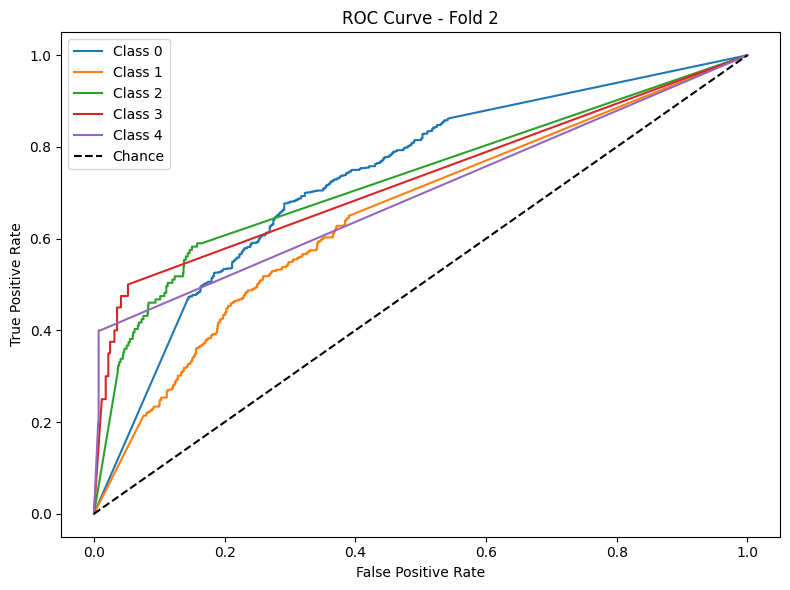


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.71      0.76       999
           1       0.40      0.49      0.44       355
           2       0.37      0.45      0.41       139
           3       0.34      0.42      0.38        40
           4       0.30      0.50      0.37         6

    accuracy                           0.63      1539
   macro avg       0.44      0.52      0.47      1539
weighted avg       0.66      0.63      0.64      1539



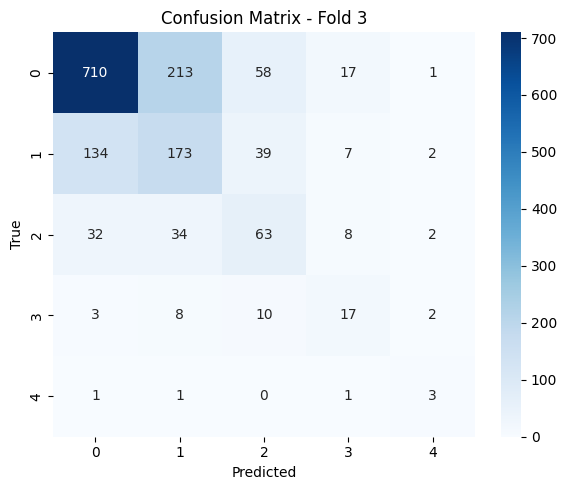

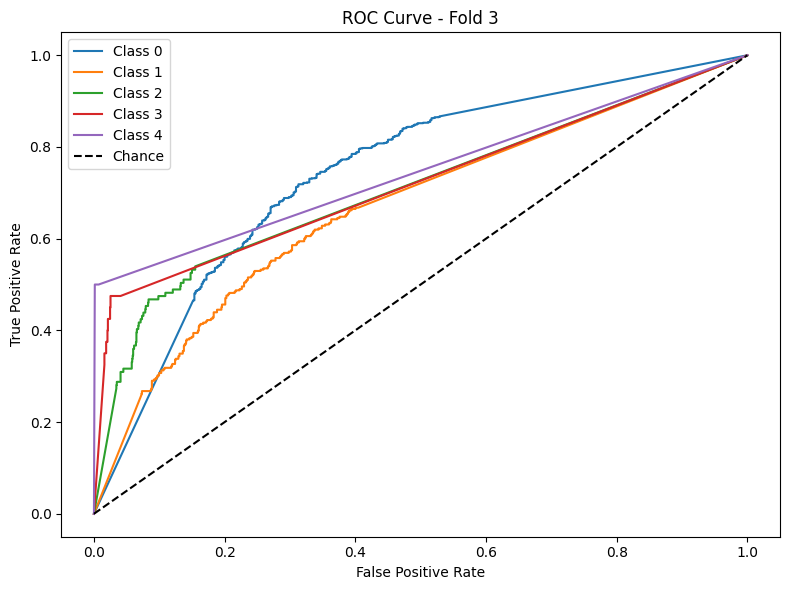


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.71      0.76       999
           1       0.41      0.46      0.43       356
           2       0.35      0.49      0.40       138
           3       0.20      0.31      0.24        39
           4       0.14      0.17      0.15         6

    accuracy                           0.62      1538
   macro avg       0.38      0.43      0.40      1538
weighted avg       0.66      0.62      0.63      1538



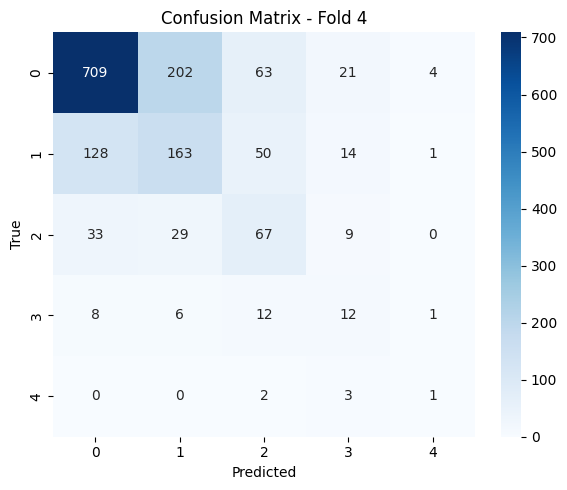

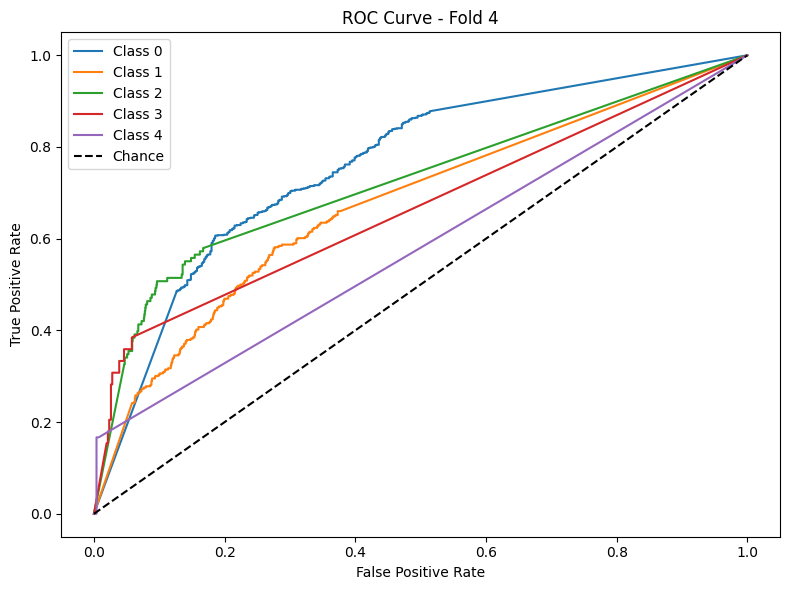


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.70      0.74       999
           1       0.39      0.46      0.42       356
           2       0.29      0.37      0.33       138
           3       0.27      0.44      0.33        39
           4       0.18      0.33      0.24         6

    accuracy                           0.61      1538
   macro avg       0.39      0.46      0.41      1538
weighted avg       0.64      0.61      0.62      1538



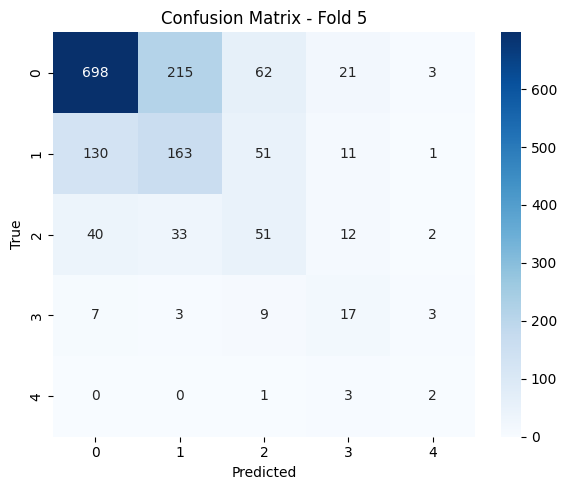

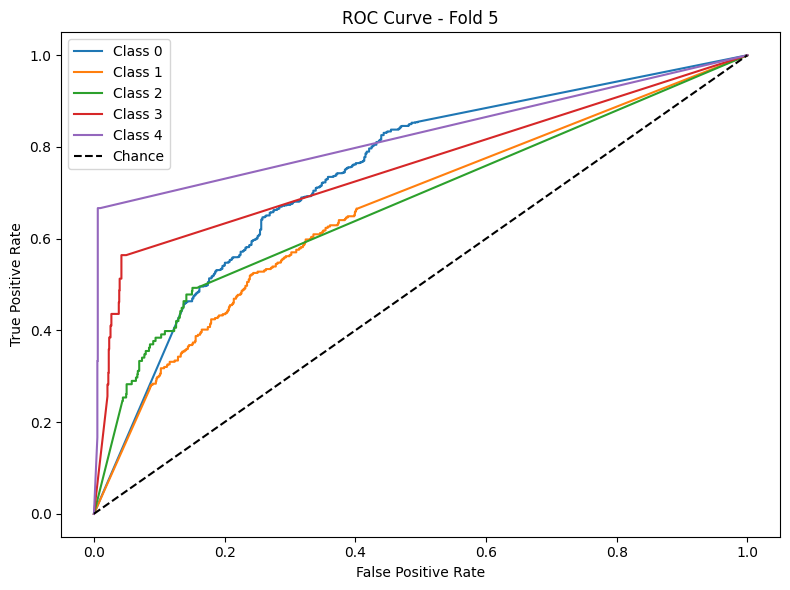


Average Accuracy: 0.6124
Average F1 Macro: 0.4138
Average AUC: 0.7010


In [8]:
phase_paths = [f"/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = True
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.77      0.82       568
           1       0.11      0.21      0.14        63
           2       0.17      0.23      0.20        43
           3       0.08      0.07      0.07        15
           4       0.00      0.00      0.00         9

    accuracy                           0.66       698
   macro avg       0.25      0.26      0.25       698
weighted avg       0.73      0.66      0.69       698



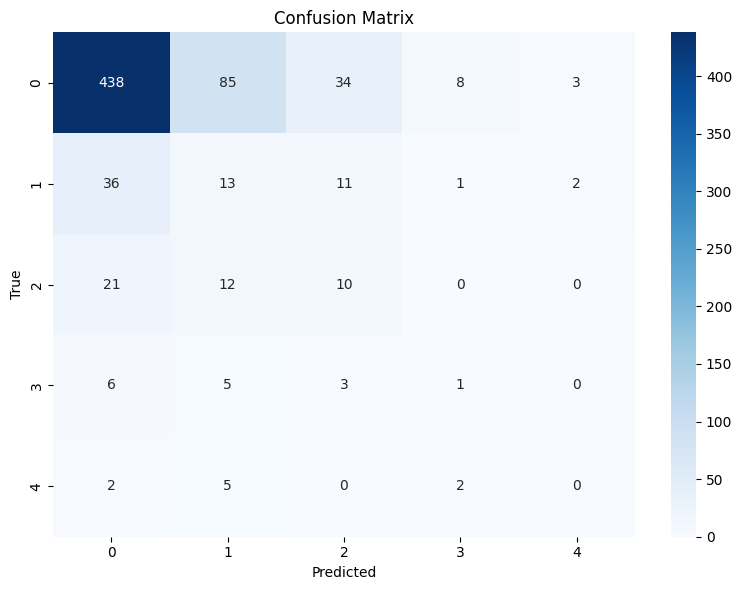


Test AUC (macro-average, OVR): 0.5764


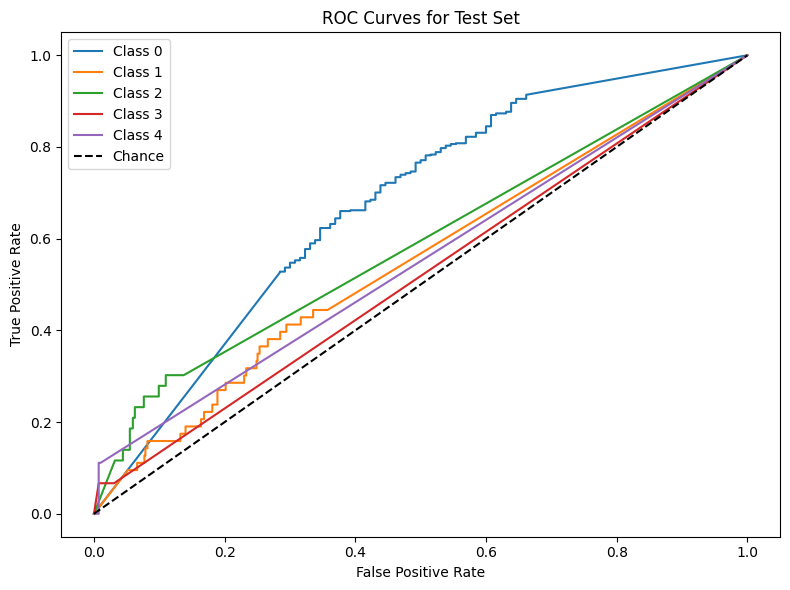

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       544
           1       0.14      0.20      0.17        59
           2       0.12      0.17      0.14        42
           3       0.08      0.14      0.10        14
           4       0.00      0.00      0.00         9

    accuracy                           0.68       668
   macro avg       0.24      0.26      0.25       668
weighted avg       0.74      0.68      0.70       668



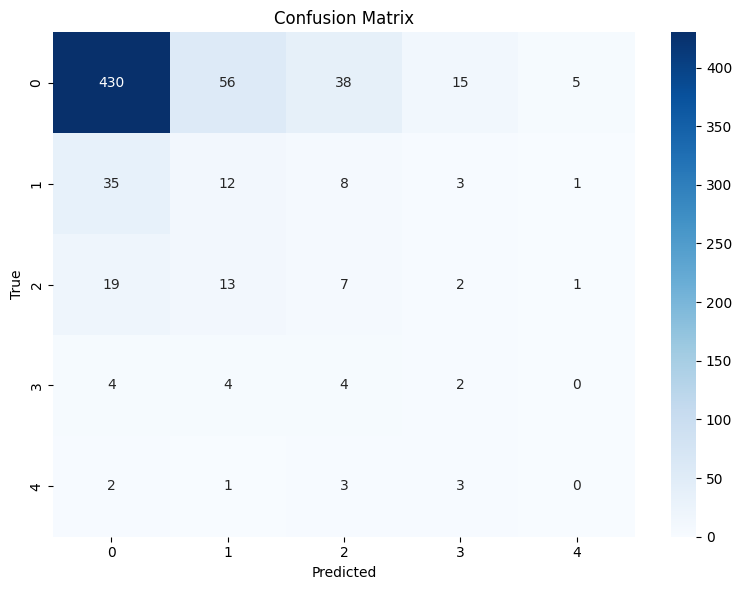


Test AUC (macro-average, OVR): 0.5960


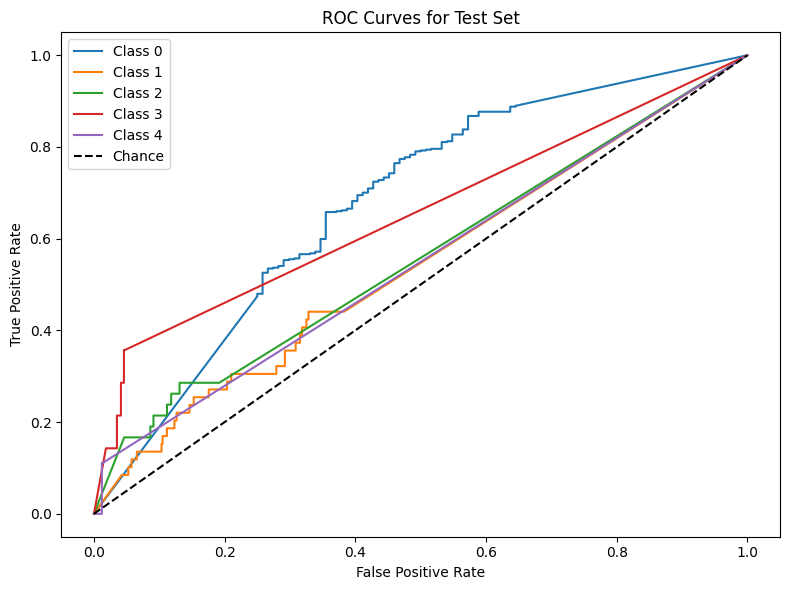

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.69      0.79       455
           1       0.16      0.23      0.19        52
           2       0.10      0.31      0.15        29
           3       0.17      0.50      0.26        10
           4       0.14      0.12      0.13         8

    accuracy                           0.62       554
   macro avg       0.29      0.37      0.30       554
weighted avg       0.77      0.62      0.68       554



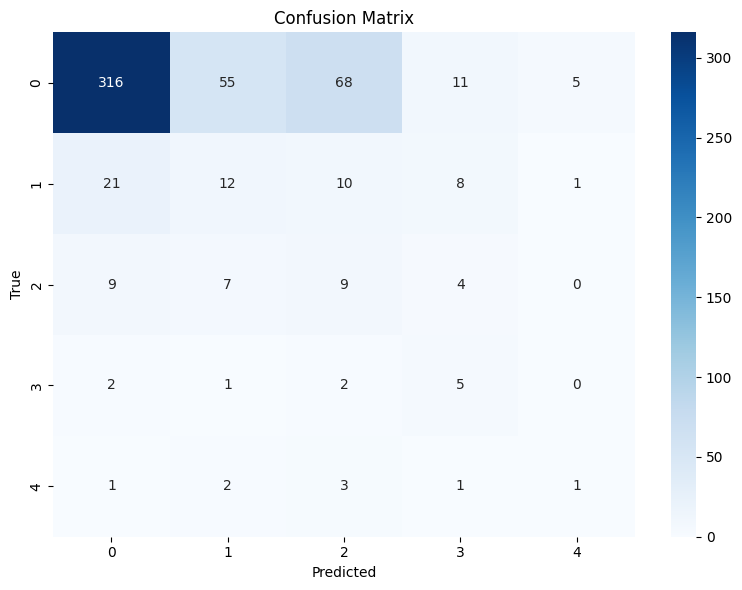


Test AUC (macro-average, OVR): 0.6225


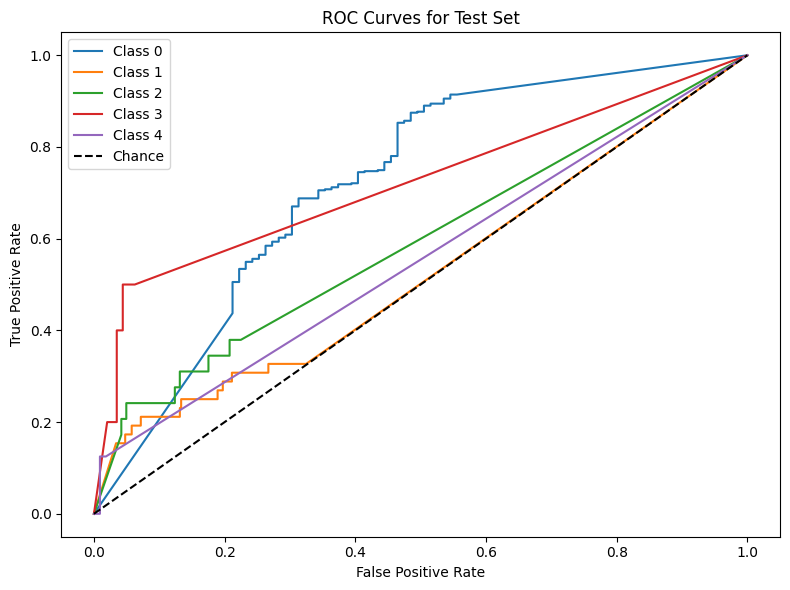

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       395
           1       0.11      0.12      0.11        40
           2       0.12      0.29      0.18        24
           3       0.00      0.00      0.00        10
           4       0.12      0.12      0.12         8

    accuracy                           0.68       477
   macro avg       0.25      0.27      0.25       477
weighted avg       0.75      0.68      0.71       477



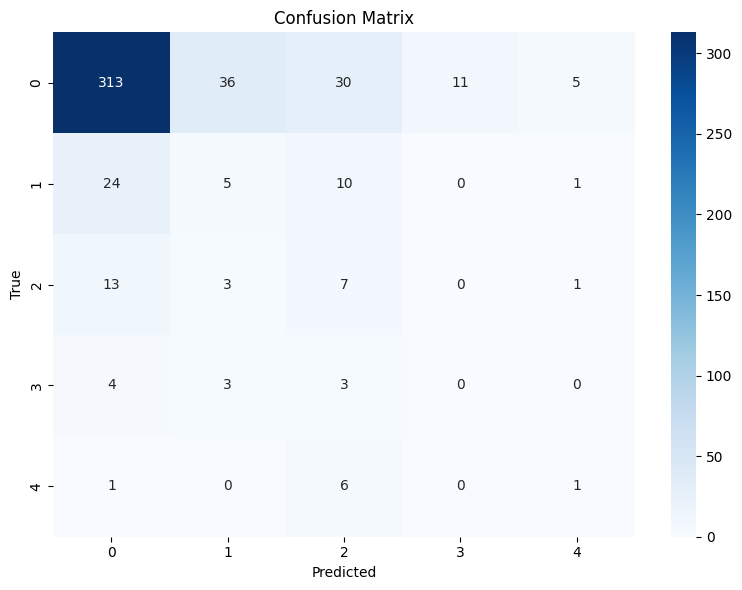


Test AUC (macro-average, OVR): 0.5938


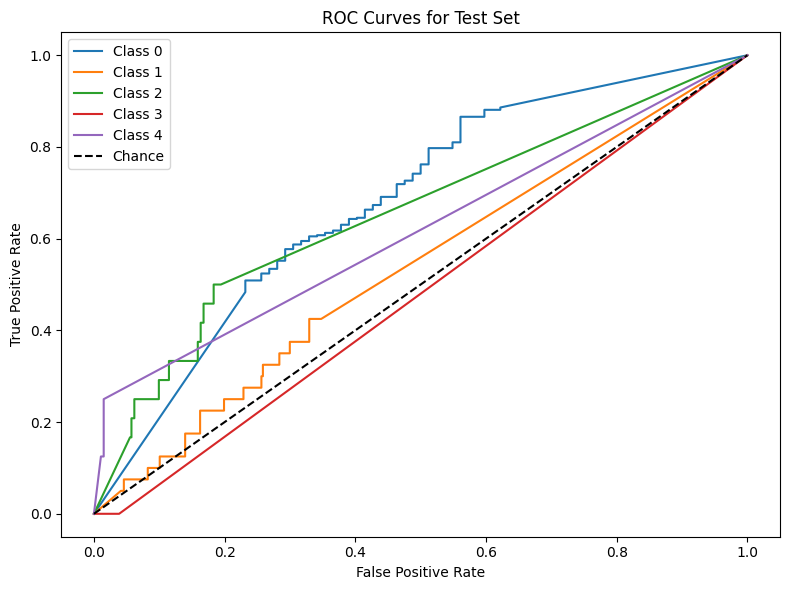

In [9]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-using-node2vector/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)
